<a href="https://colab.research.google.com/github/thaleshenckes/portfolio_projetos/blob/main/DS_em_Produ%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [ ]:
#!pip install inflection
#!pip install --upgrade matplotlib
#!pip install boruta

import pandas as pd
import inflection
import math
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from IPython.core.display import HTML
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Helper functions

In [2]:
def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

def cramer_v (x,y):
  cm =pd.crosstab(x,y).values
  n = cm.sum()  
  r, k = cm.shape

  chi2 = stats.chi2_contingency(cm)[0]
  
  chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
  kcorr = k-(k-1)**2/(n-1)
  rcorr = r-(r-1)**2/(n-1)

  return np.sqrt((chi2/n)/(min(k-1,r-1)))

def mean_absolute_percentage_error(y, yhat):
  return np.mean(np.abs((y-yhat)/y))

def ml_error (model_name, y, yhat):
  mae = mean_absolute_error(y, yhat)
  mape = mean_absolute_percentage_error(y, yhat)
  rmse = np.sqrt(mean_squared_error(y,yhat))
  return pd.DataFrame({'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse}, index = [0])

def cross_validation (x_training, kfold, model_name, model, verbose=False):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed(range(1,kfold+1)):
    if verbose:
      print('\nKfold: {}'.format(k))
    #start and end date for validation 
    validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

    #filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    #training and validation dataset
    #training
    xtraining = training.drop(['date','sales'], axis = 1)
    ytraining = training['sales']

    #validation
    xvalidation = validation.drop(['date','sales'], axis = 1)
    yvalidation = validation['sales']

    #Model
    m = model.fit(xtraining, ytraining)

    #prediction
    yhat = m.predict(xvalidation)

    #performance
    m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
    #store perfomance of each kfold iteration
    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  return pd.DataFrame({'Model Name:': model_name,
                  'MAE CV': np.round(np.mean(mae_list),2).astype(str) +' +/- ' + np.round(np.std(mae_list),2).astype(str),
                  'MAPE CV': np.round(np.mean(mape_list),2).astype(str) +' +/- '+ np.round(np.std(mape_list),2).astype(str),
                  'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) +' +/- '+ np.round(np.std(rmse_list),2).astype(str)}, index = [0])

In [3]:
jupyter_settings()


Populating the interactive namespace from numpy and matplotlib


#### Loading data:


In [4]:
df_sales_raw = pd.read_csv('train.csv')
df_stores_raw = pd.read_csv('store.csv')

#merge
df_raw = pd.merge(df_sales_raw, df_stores_raw, how = 'left', on ='Store')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### 1.0 Descrição dos dados:

In [5]:
df1 = df_raw.copy()

##### 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map (snakecase, cols_old))

df1.columns = cols_new

#####1.2. Data Dimensions

In [7]:
print ('Number of rows: {}'.format(df1.shape[0]))
print ('number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
number of cols: 18


#####1.3. Data Types

In [8]:
#formatar Date de object para date
df1['date'] = pd.to_datetime(df1['date'])


df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

#####1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

##### 1.5 Substituindo os dados vazios (fillout NA)

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan (x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                                             
#promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1) 

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)  


#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

##### Estatistica descritiva:

###### 1.6 Change types

In [11]:
a = df1.dtypes
print(a)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


In [12]:
#transformando de float para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

##### 1.7 Descriptive Statistical

In [14]:
#Num attributes
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

#cat attributes
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

###### 1.7.1 Numerical Attributes

In [15]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
                   
#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
#
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='customers', ylabel='Density'>

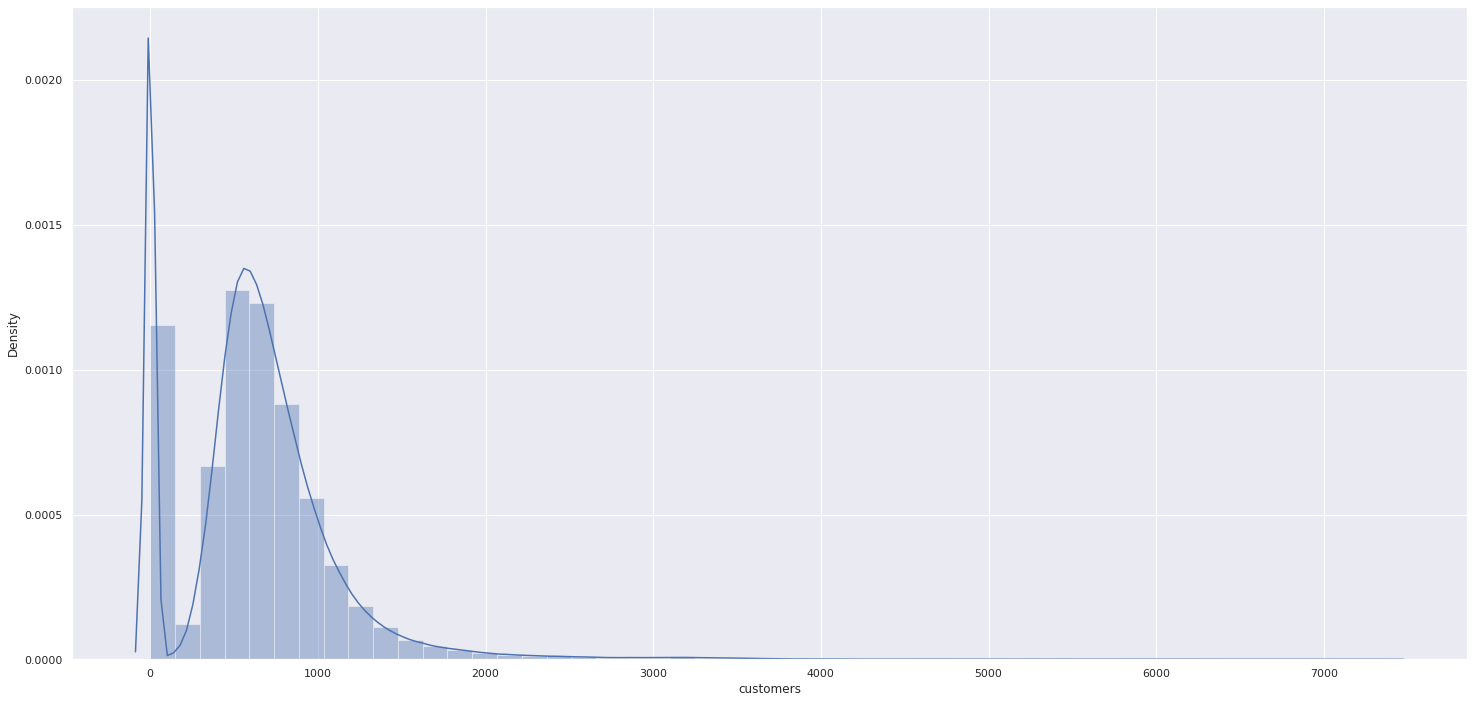

In [17]:
sns.distplot(df1['customers'])


###### 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

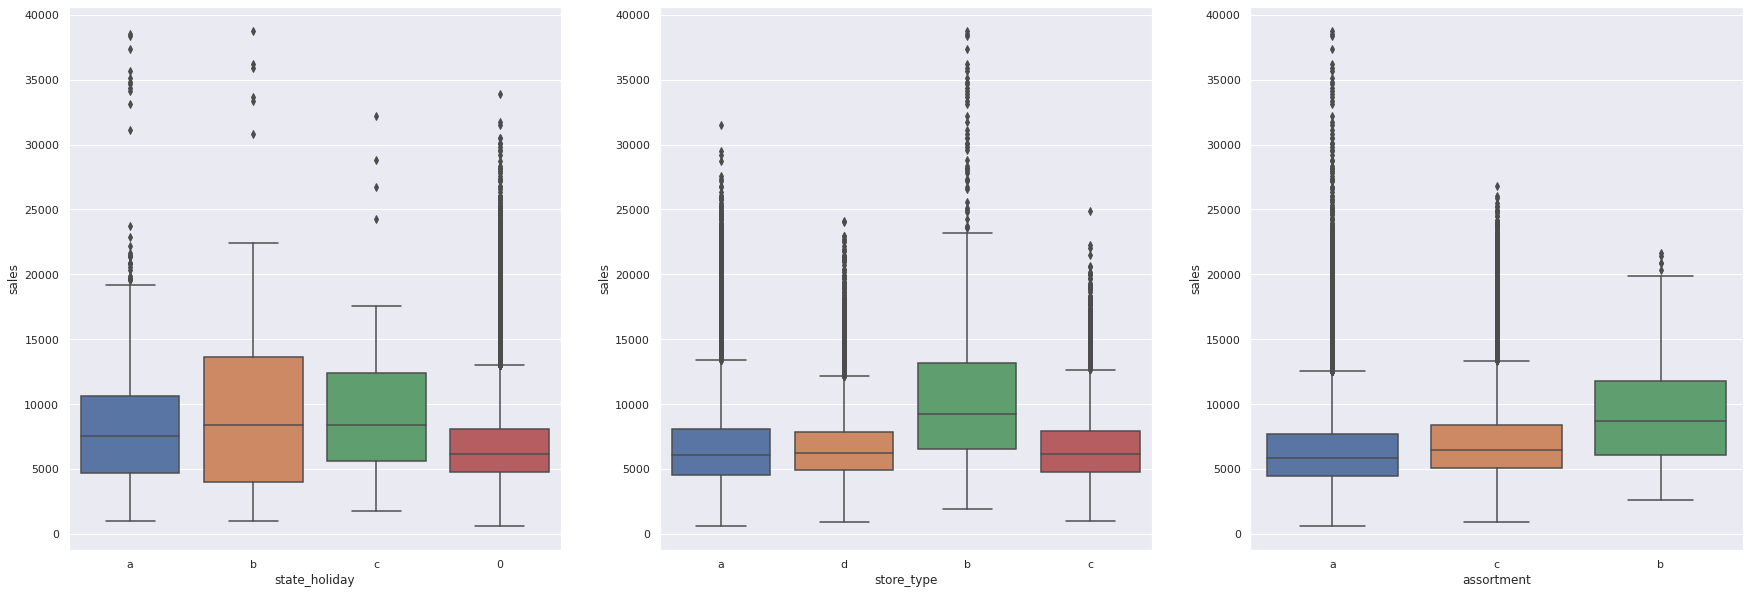

In [19]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
sns.boxplot(x= 'state_holiday', y= 'sales' , data = aux1)
plt.subplot(1,3,2)
sns.boxplot(x= 'store_type', y= 'sales' , data = aux1)
plt.subplot(1,3,3)
sns.boxplot(x= 'assortment', y= 'sales' , data = aux1)

#### 2.0 Feature Engineering

Ter as variáveis disponíveis para estudo durante a Análise Exploratória de dados.

##### Mapa mental de hipóteses


Fenômeno:
* qual fenômeno estou modelando

Agente:
* Quem são os agentes que atuam sobre o fenômeno de interesse

Atributos dos agentes:
* Qual a descrição dos agentes

Lista de hipóteses:
* Hipóteses para validar com os dados

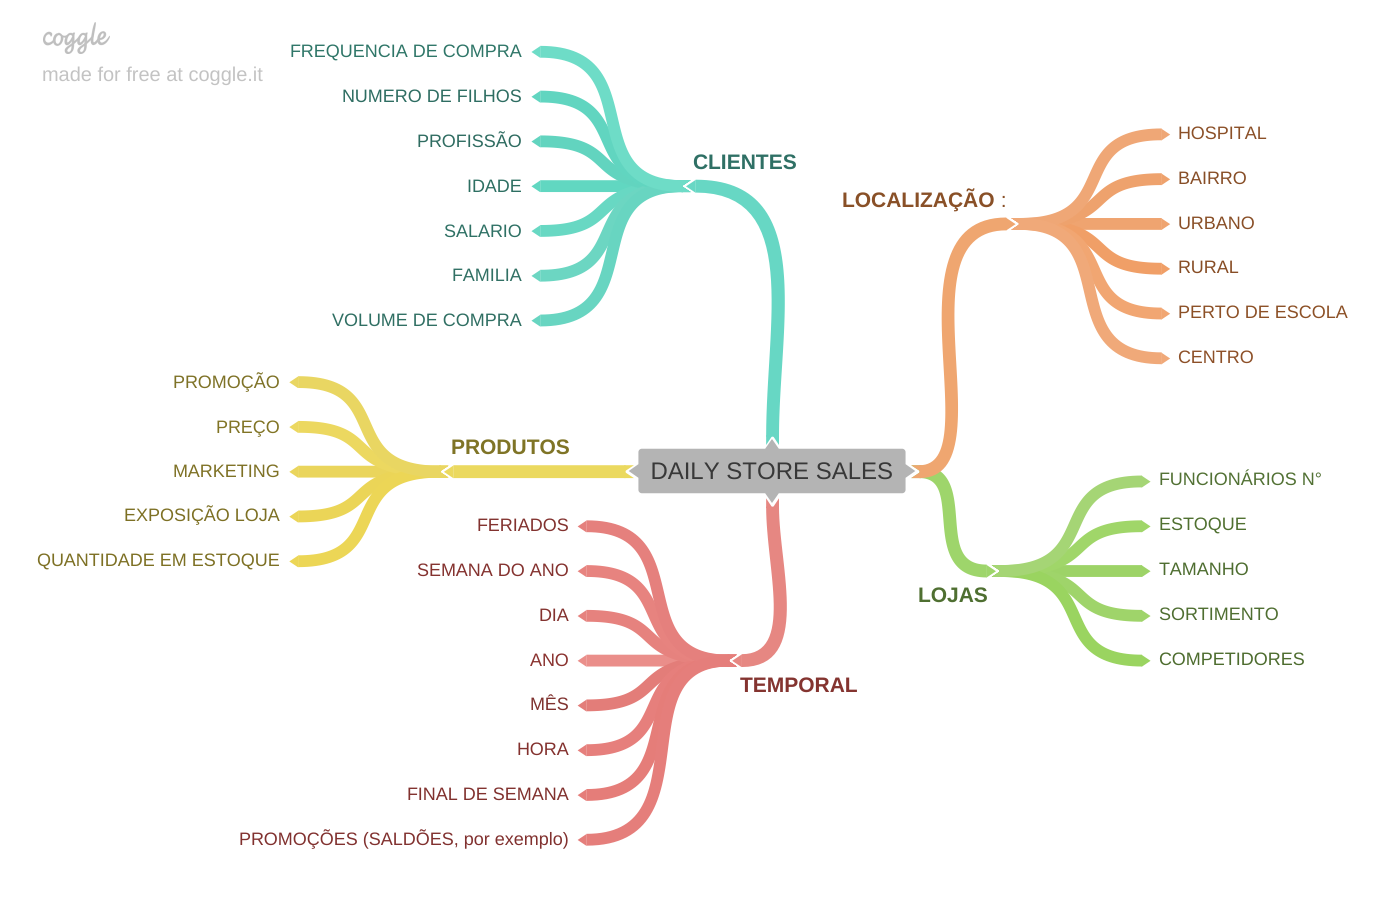

##### 2.1 MAPA MENTAL DE HIPÓTESES

**Hipóteses** são APOSTAS:

Ex.: 
- Lojas de MAIOR PORTE deveriam vender MAIS
- Lojas de MAIOR SORTIMENTO deveriam vender MAIS
- Lojas de MAS COMPETIDORES por perto deveriam vender MENOS

###### 2.1.1 HIPÓTESES LOJA

1. Lojas com **maior** quadro de funcionários deveriam vender MAIS!
2. Lojas com **maior** estoque deveriam vender MAIS!
3. Lojas com **maior** porte deveriam vender MAIS!
4. Lojas com **menor** porte deveriam vender MENOS!
5. Lojas com **maior** sortimento deveriam vender MAIS!
6. Lojas com competidores mais próximos deveriam vender menos
7. Lojas com competidores à mais tempo deveriam vender mais

###### 2.1.2 HIPÓTESES PRODUTO



1. Lojas que investem **mais** em marketing deveriam vender MAIS!
2. Lojas que expõe **mais** os produtos na vitrine deveriam vender MAIS!
3. Lojas que tem preços **menores** nos produtos deveriam vender MAIS!
4. Lojas que tem preços **menores** por mais tempo nos produtos deveriam vender MAIS!
5. Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais
6. Lojas com promoções ativas por mais tempo deveriam vender mais
7. Lojas com mais dias de promoção deveriam vender mais
8. Lojas com mais promoções consecutivas deveriam vender mais

###### 2.1.3 HIPÓTESES TEMPO

1. lojas abertas durante o feriado de natal deveriam vender mais
2. lojas deveriam vender mais ao longo dos anos
3. lojas deveriam vender mais no segundo semestre do ano
4. lojas deveriam vender mais depois do 10 de cada mês
5. Lojas deveriam vender menos aos finais de semana
6. lojas deveriam vender menos durante os feriados


##### 2.2 Priorização de Hipóteses (lista final de hipóteses)

Neste caso, buscamos criar uma lista baseado na facilidade de acesso aos dados para extração das informações, ou seja, que já possuí dados prontos para análise. 

Como utilizamos o metódo crisp podemos ir verificando, a cada ciclo, o desempenho do modelo e a necessidade de melhorias, seja através da adição/refinamento dos dados

**Lista de hipóteses por prioridade de averiguação**

*Lojas*
1. Lojas com **maior** sortimento deveriam vender MAIS!
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores à mais tempo deveriam vender mais

*Produto*
4. Lojas com promoções ativas por mais tempo deveriam vender mais
5. Lojas com mais dias de promoção deveriam vender mais
6. Lojas com mais promoções consecutivas deveriam vender mais

*Tempo*
7. Lojas abertas durante o feriado de natal deveriam vender mais
8. Lojas deveriam vender mais ao longo dos anos
9. Lojas deveriam vender mais no segundo semestre do ano
10. Lojas deveriam vender mais depois do 10 de cada mês
11. Lojas deveriam vender menos aos finais de semana
12. Lojas deveriam vender menos durante os feriados


##### 2.3 Derivação de FEATURE

In [20]:
#cópia do dataframe para salvamento de dados
df2 = df1.copy()

In [21]:


#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of Year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year Week
df2['year_week'] = df2['date'].dt.strftime('%y-%W')
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month=x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1','%Y-%W-%w') - datetime.timedelta(days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

<ipython-input-21-b13d163ea369>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [22]:
df2.sample(4).T

,211566,176719,76681,931467
store,832,550,862,113
day_of_week,5,1,7,1
date,2015-01-23 00:00:00,2015-02-23 00:00:00,2015-05-24 00:00:00,2013-03-18 00:00:00
sales,5298,4881,0,9515
customers,510,433,0,791
open,1,1,0,1
promo,0,0,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0
store_type,d,d,a,d


##### Filtragrem das variaveis

A motivação da filtragem das variáveis são as restrições de negócios.

É de suma importância pensar nas restrições de negócios antes de filtrar as variáveis, para que ao fim do estudo, seja possível por em produção.

Por outro lado, há ainda a seleção de variáveis, que são as variáveis mais impactantes para o modelo, geralmente decididas através de algoritmo, contudo, não leva em conta as restrições de negócios.

A função de considerar os melhores resultados possíveis dado as restrições de negócios é do cientista de dados.


#### 3.0 Filtragem de variáveis

In [23]:
df3 = df2.copy()

###### 3.1 Filtragem das linhas

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

###### 3.2 Filtragem das colunas

In [25]:
cols_drop = ['customers', 'open', 'promo_interval','month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [26]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

#### 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

"*Como as variáveis impactam o fenômeno? E qual a força desse impacto?*"

Quais os 3 Objetivos da EDA?

1. Ganhar experiência de negócio.
2. Validar hipóteses de negócio. (Insights)
3. Perceber variáveis que são importantes para o modelo

Análise Univariada:
  * Como é essa variável? (min, max, distribuição, range,...);

Análise Bivariada:
  * Como a variável impacta na resposta? (correlação, validação das hipóteses,...)

Análise Multivariada:
  * Como as varáveis se relacionam?

In [27]:
df4 = df3.copy()

##### 4.1 Analise Univariada


###### 4.1.1 Response variable


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='sales', ylabel='Density'>

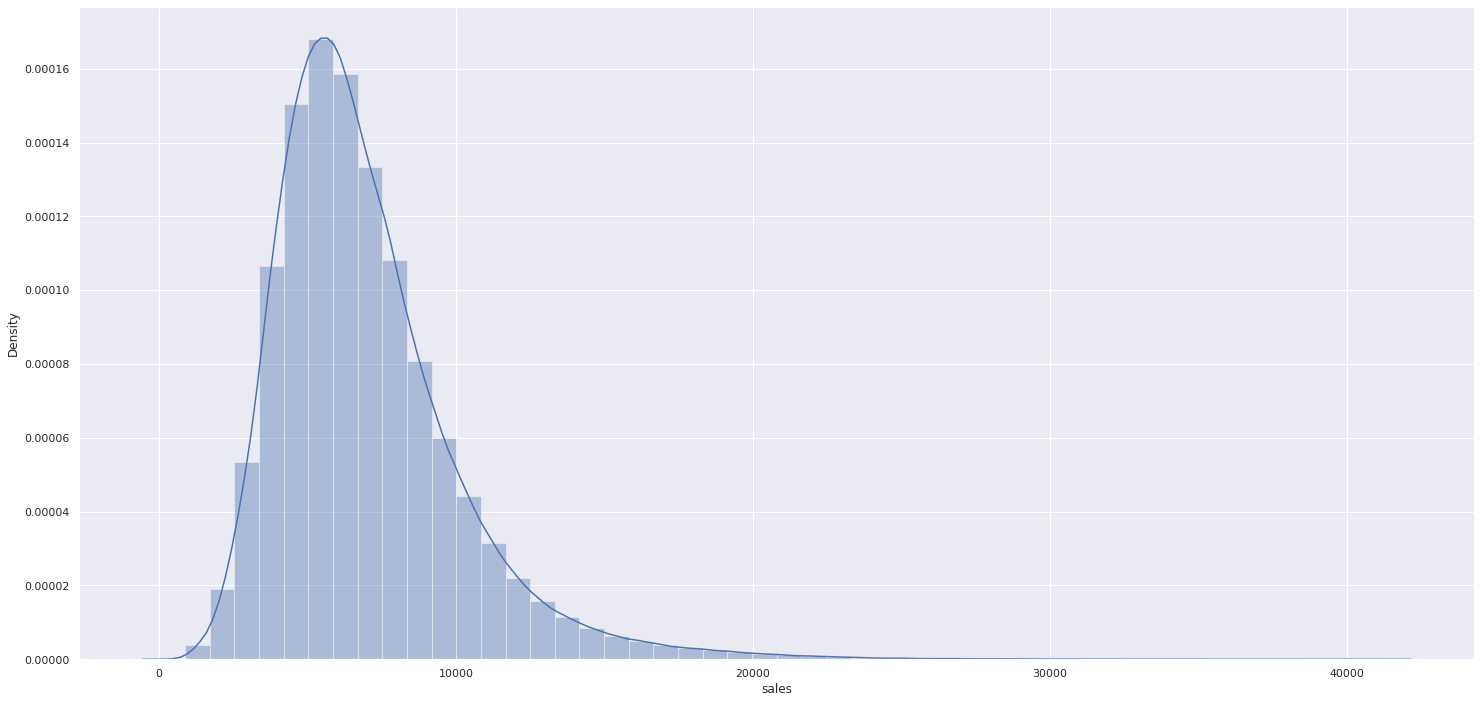

In [28]:
sns.distplot(df4['sales'])

###### 4.1.2 Numerical variable

<ipython-input-29-d08e2d3e381c>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_attributes.hist(ax = ax, bins = 25);


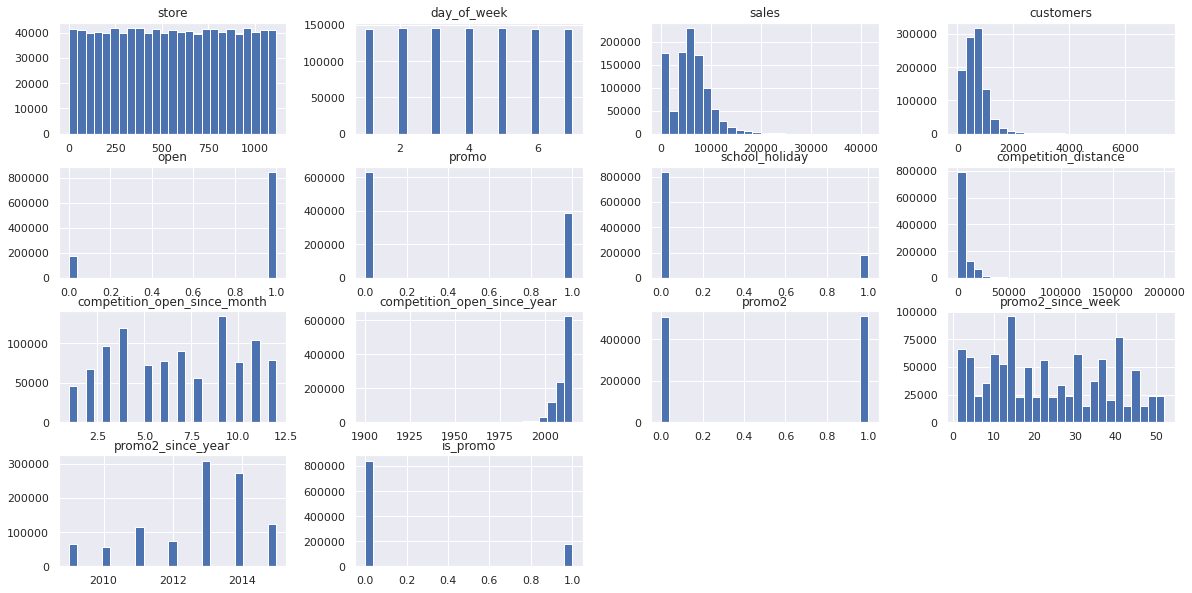

In [29]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
num_attributes.hist(ax = ax, bins = 25);


###### 4.1.3 Categorical variable

In [30]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


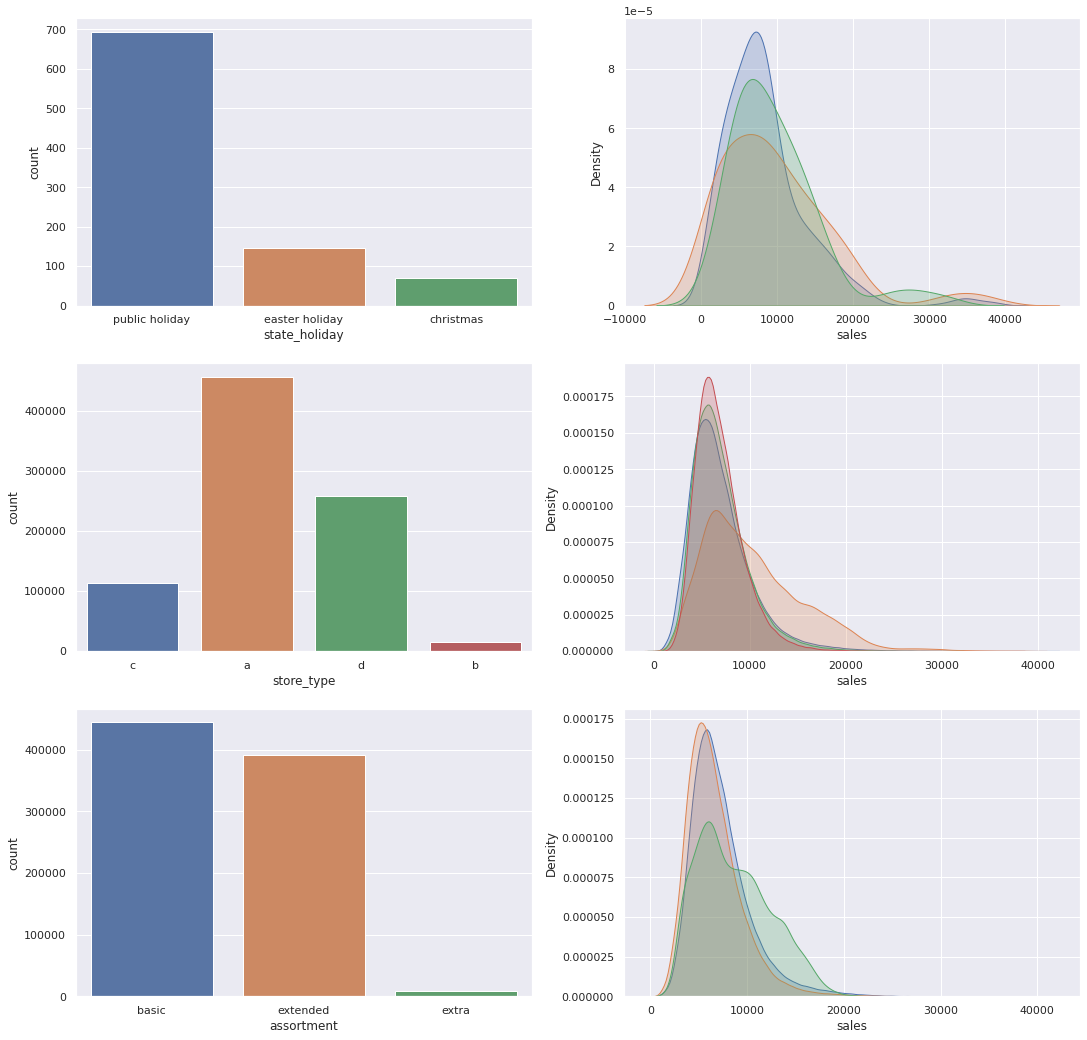

In [31]:
fig = plt.figure(figsize = (18,18))
#state_holiday
plt.subplot(3,2,1)

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public holiday']['sales'], label = 'public holiday', shade = True);
sns.kdeplot( df4[df4['state_holiday'] == 'easter holiday']['sales'], label = 'easter holiday', shade = True);
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True);
#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True);
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True);
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True);
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'c', shade = True);

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label= 'extended', shade = True);
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label= 'basic', shade = True);
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label= 'extra', shade = True);

plt.show()


##### 4.2 Analise Bivariada


h1. lojas com maior sortimento deveriam vender mais.
 - a hipótese (h1) é FALSA

h2. lojas com competidores mais proximos deveriam vender menos.
- a hipótese (h2) é FALSA

h3. lojas com competidores à mais tempos deveriam vender mais.
- a hipótese (h3) é FALSA, pois lojas com ompetidores a mais não vendem mais.

<Axes: xlabel='assortment', ylabel='sales'>

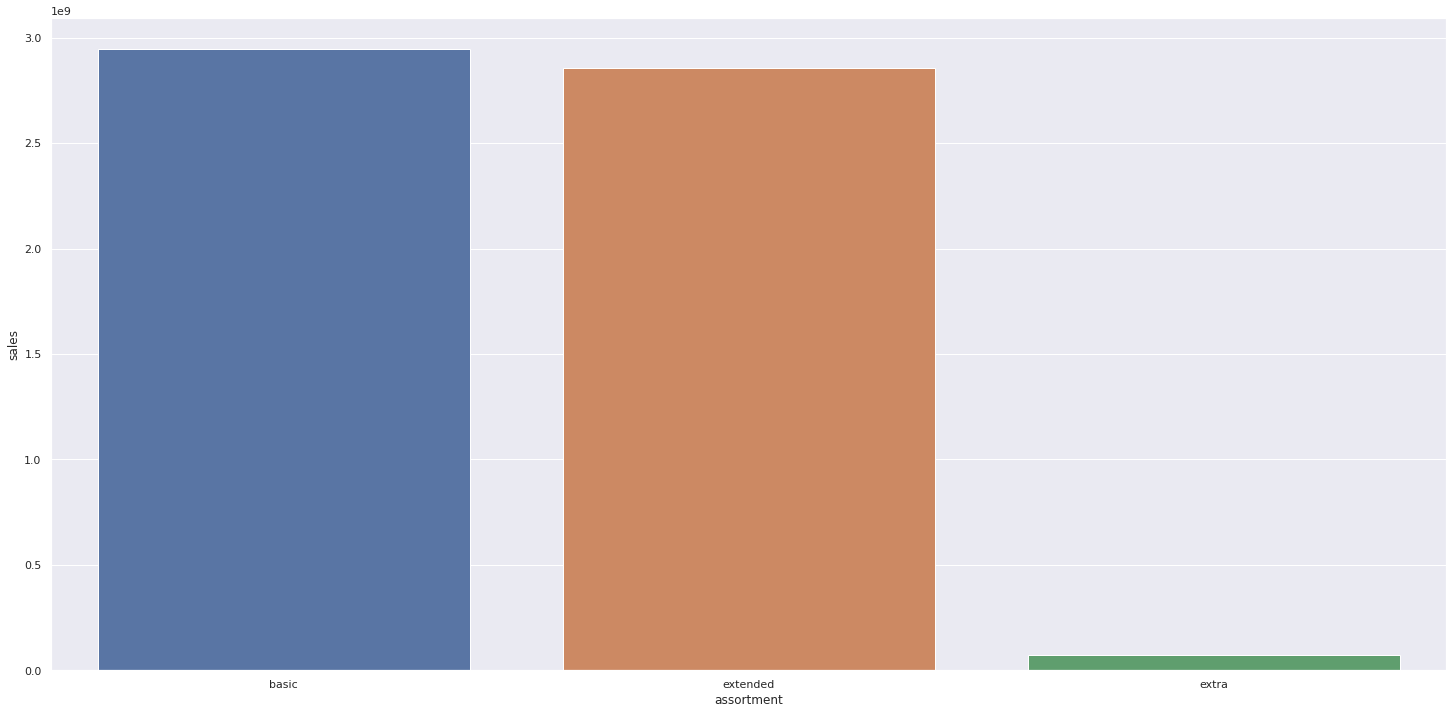

In [32]:
#h1. lojas com maior sortimento deveriam vender mais.

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot (x='assortment', 
             y='sales', 
             data = aux1)

<Axes: xlabel='year_week'>

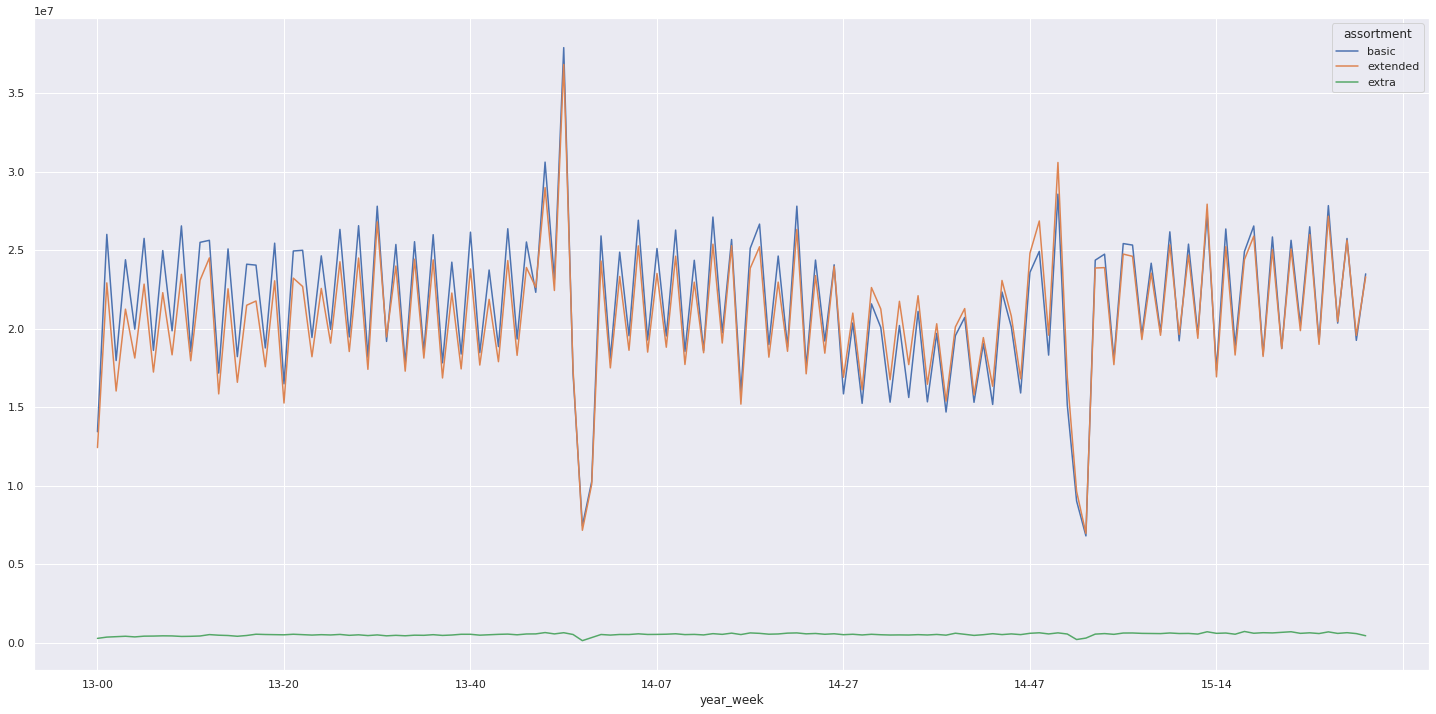

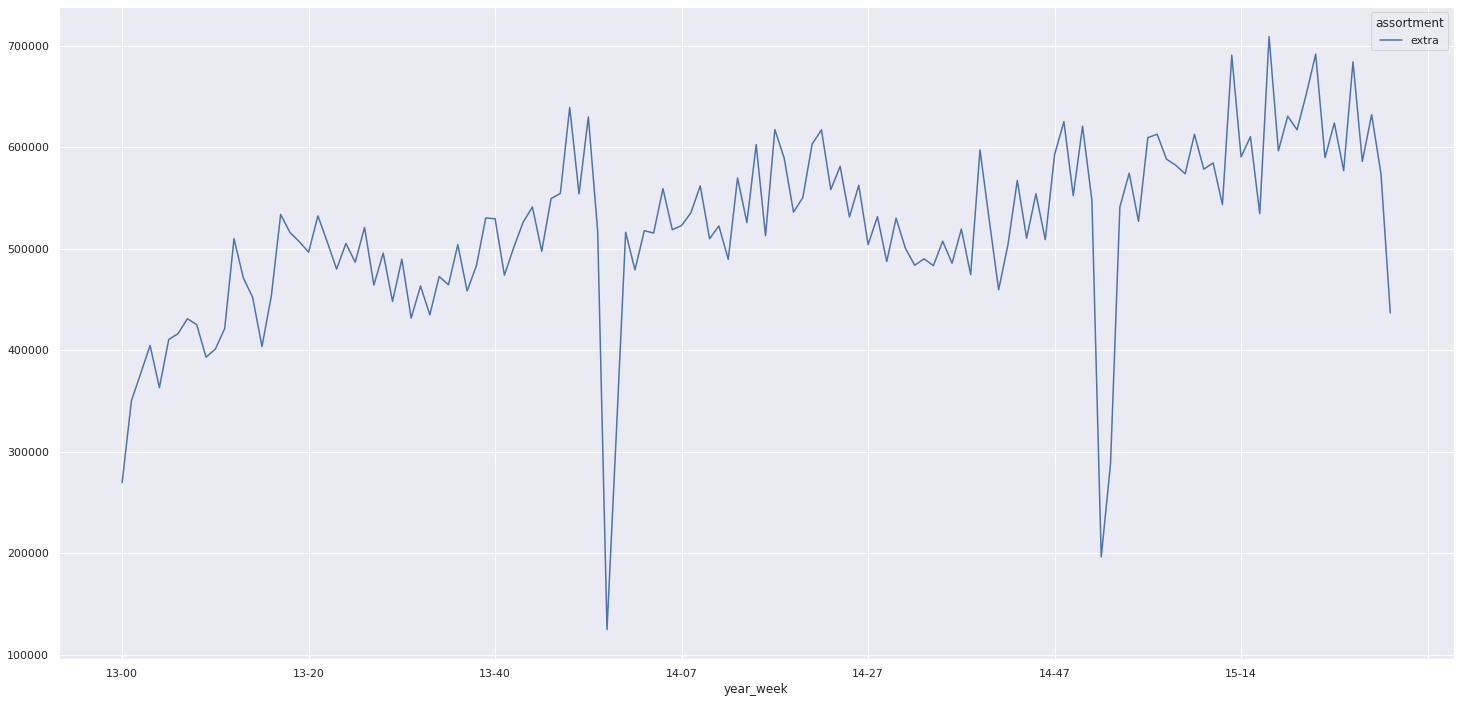

In [33]:
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()

aux2.pivot(index ='year_week', columns ='assortment' , values ='sales').plot()


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index ='year_week', columns ='assortment' , values ='sales').plot()

<Axes: >

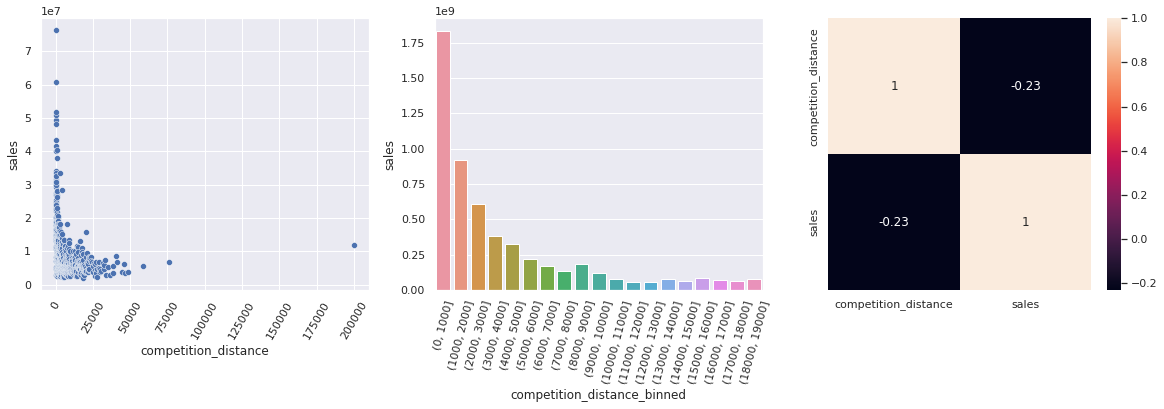

In [34]:
#h2. lojas com competidores mais proximos deveriam vender menos.

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

fig = plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
sns.scatterplot(x ='competition_distance', y='sales', data = aux1);
plt.xticks (rotation = 60);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data = aux2);
plt.xticks (rotation = 75);


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)




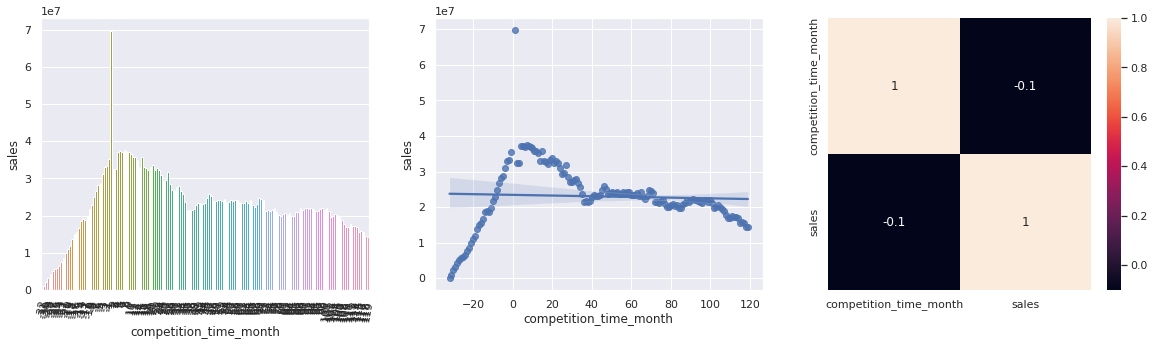

In [35]:
#h3. lojas com competidores à mais tempos deveriam vender mais.

aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

#building the graphic
fig = plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',
            y='sales',
            data= aux2);
plt.xticks (rotation = 80);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',
            y='sales',
            data= aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

plt.show()

<ipython-input-36-132c214e1ac9>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(grid[0,0])


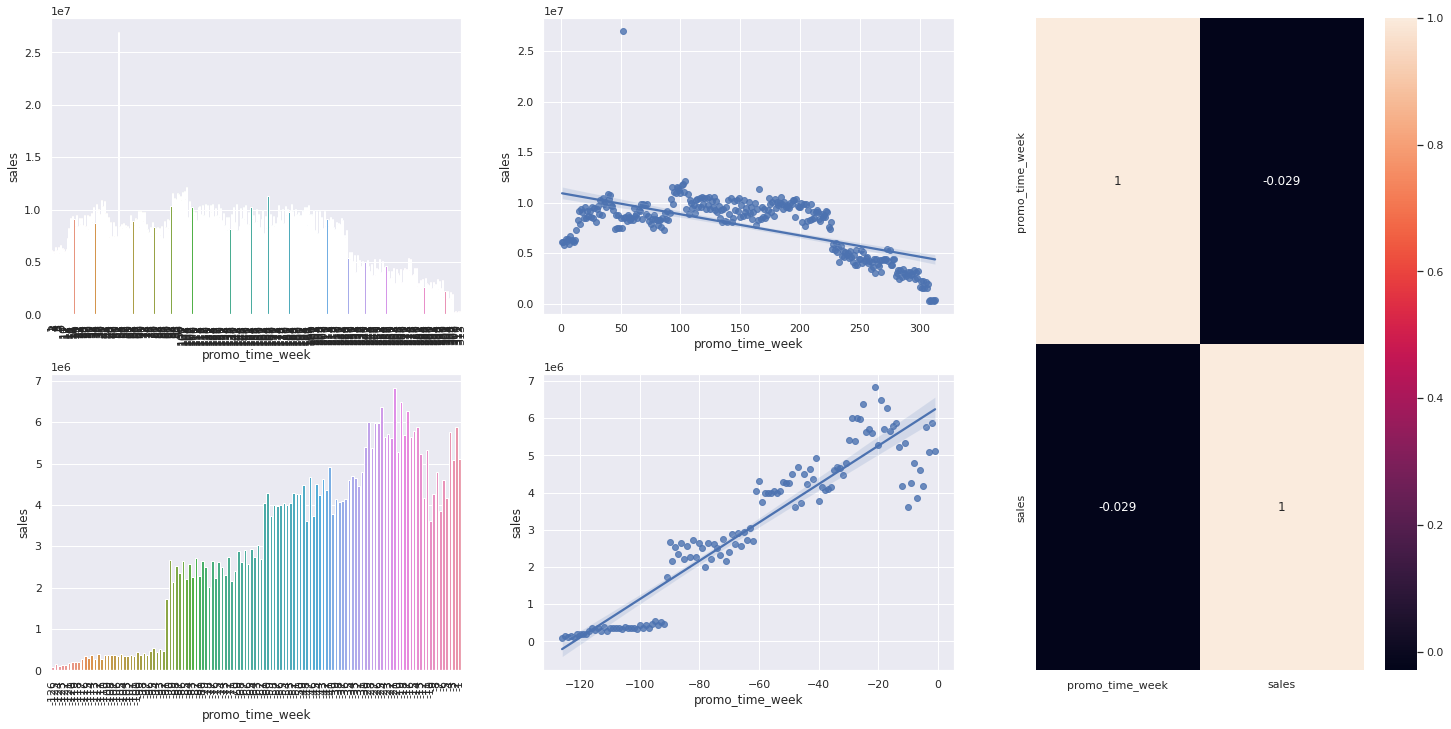

In [36]:
#Produto

#h4. Lojas com promoções ativas por mais tempo deveriam vender mais;
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week', y='sales', data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] >0]
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] <0]
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);
plt.show()



# H5 É FALSA, POIS, LOJAS COM PROMOCOES ATIVAS POR MAIS TEMPO VENDEM MENOS DEPOIS DE UM CERTO PERIODO


In [37]:
#h5. Lojas com mais dias de promoção deveriam vender mais; FICARÁ PARA O PRÓXIMO CICLO DO CRISP-DS

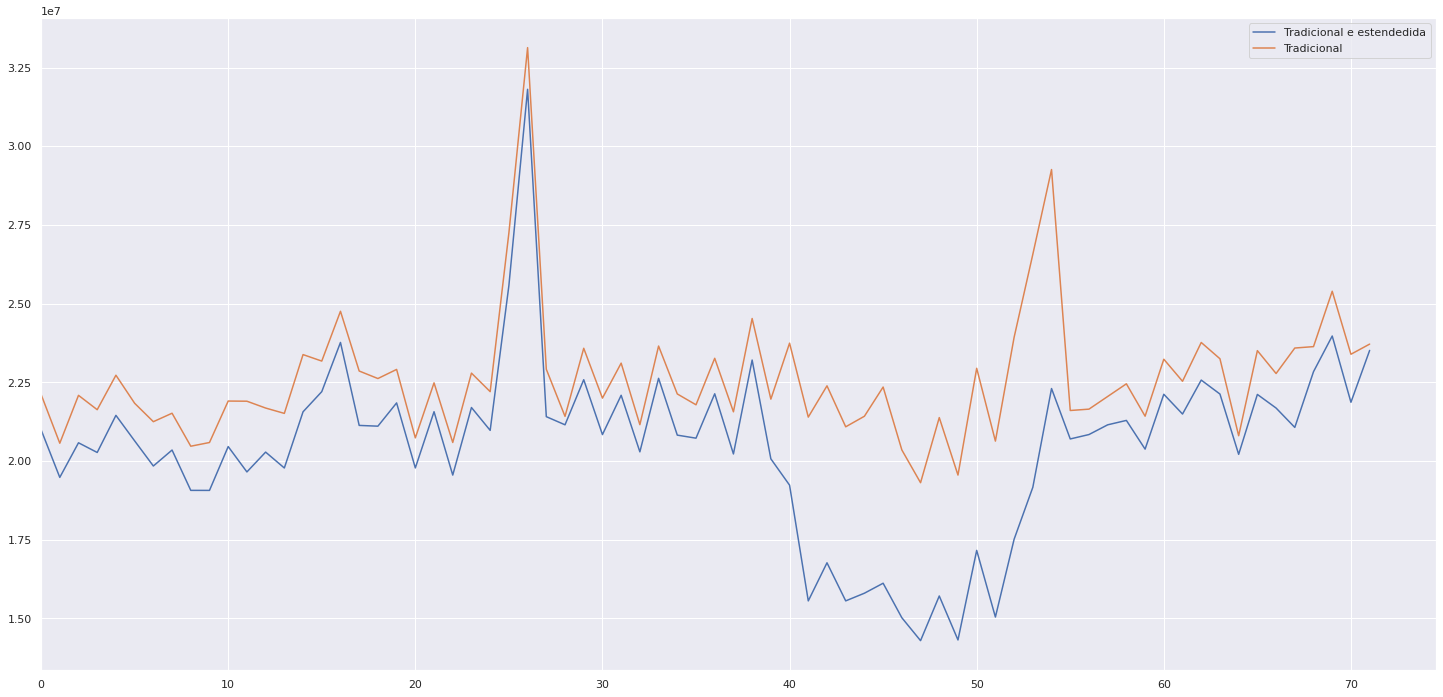

In [38]:
#h6. Lojas com mais promoções consecutivas deveriam vender mais; A AFIRMAÇÃO É FALSA, lojas com mais promocoes consecutivas vendem menos
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Tradicional e estendedida','Tradicional']);
plt.xlim(0);
plt.show()

<Axes: xlabel='year', ylabel='sales'>

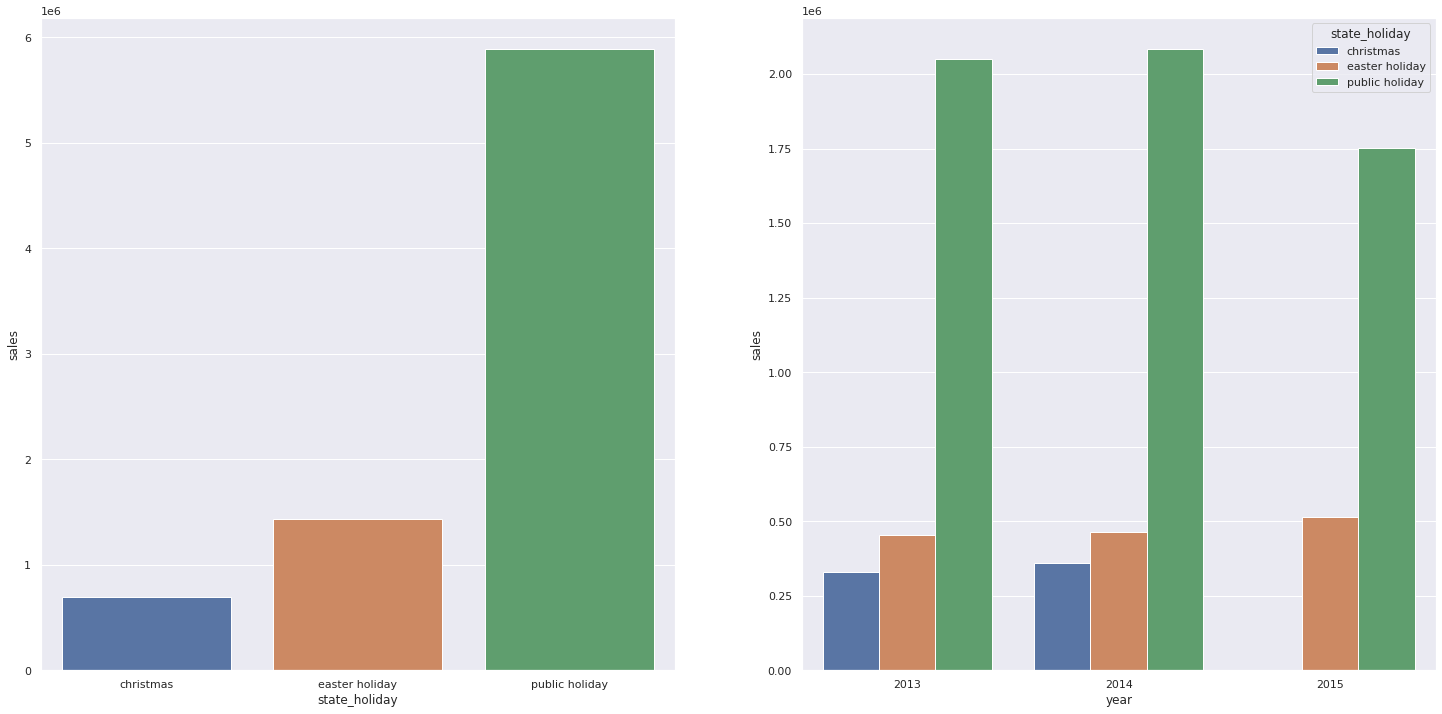

In [39]:
#Tempo
#Lojas abertas durante o feriado de natal deveriam vender mais
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue ='state_holiday', data = aux2)



#LOJAS ABERTAS DURANTE O NATAL VENDEM MENOS, PORTANTO, A PREMISSA É FALSA

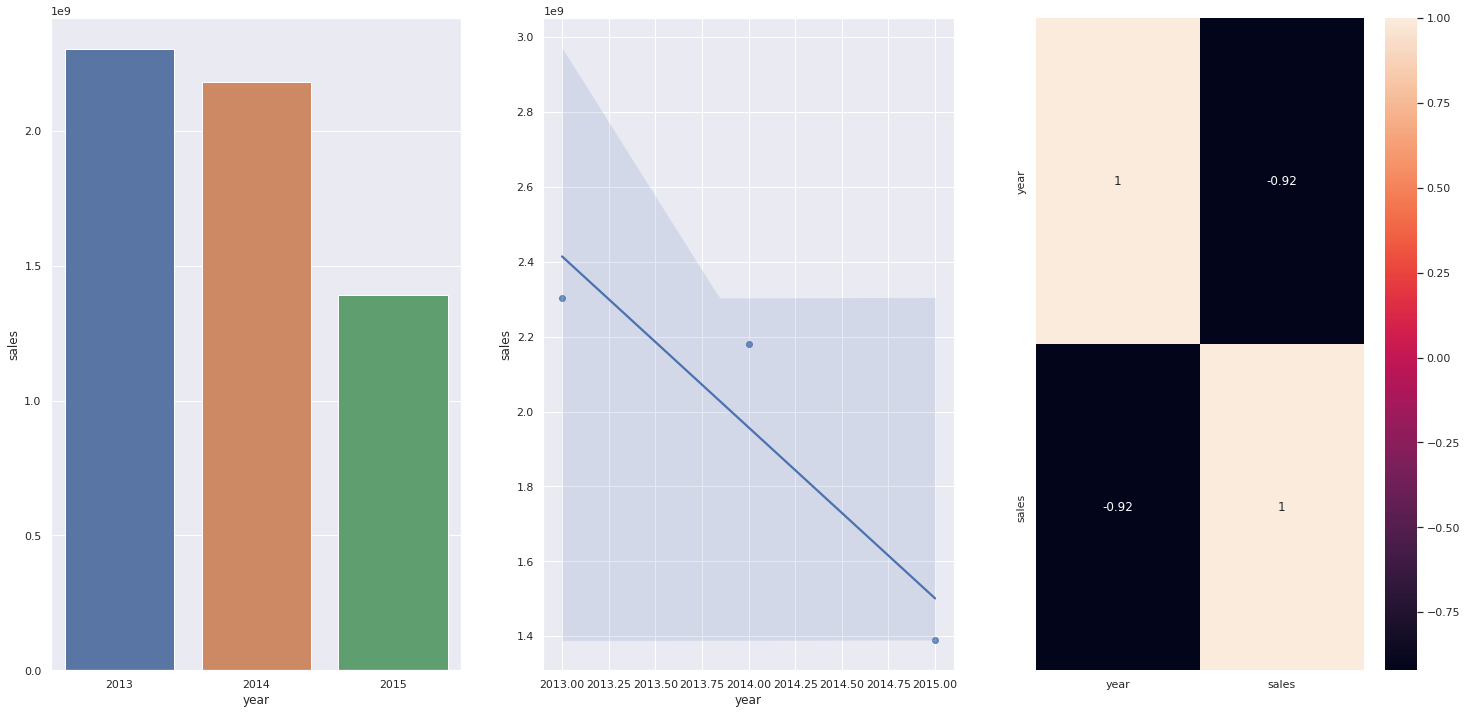

In [40]:
#Lojas deveriam vender mais ao longo dos anos

plt.subplot(1,3,1)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#a hipótese proposta é FALSA (nao esquecer que no dataset o ano de 2015 ainda não estava fechado)

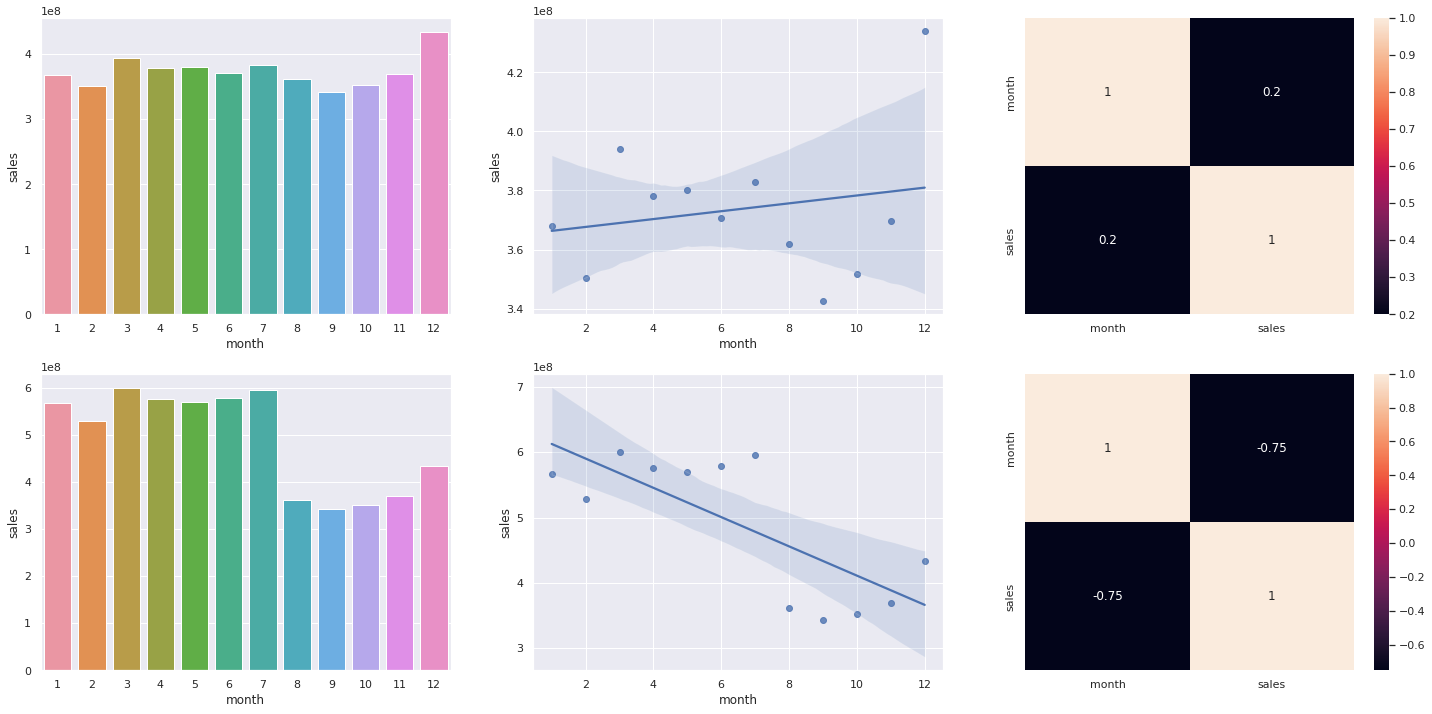

In [41]:
#Lojas deveriam vender mais no segundo semestre do ano

aux = df4[df4['year'] < 2015]

plt.subplot(2,3,1)
aux1 = aux[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data = aux1);

plt.subplot(2,3,2)
sns.regplot(x='month', y='sales', data = aux1);

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2,3,4)
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data = aux1);

plt.subplot(2,3,5)
sns.regplot(x='month', y='sales', data = aux1);

plt.subplot(2,3,6)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

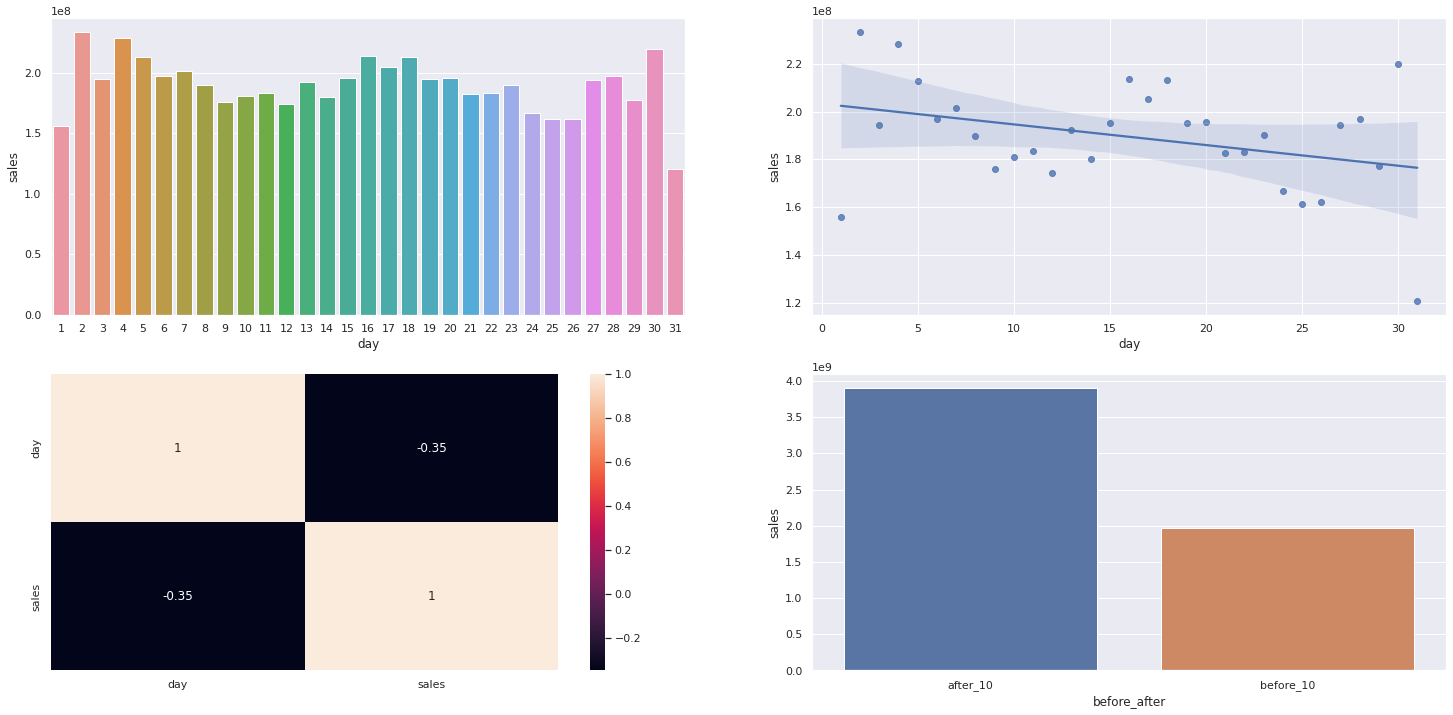

In [42]:
#Lojas deveriam vender mais depois do dia 10 de cada mês

plt.subplot(2,2,1)
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10' if x <= 10 else 'after_10')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data = aux2);


#A hipótese é verdadeira.

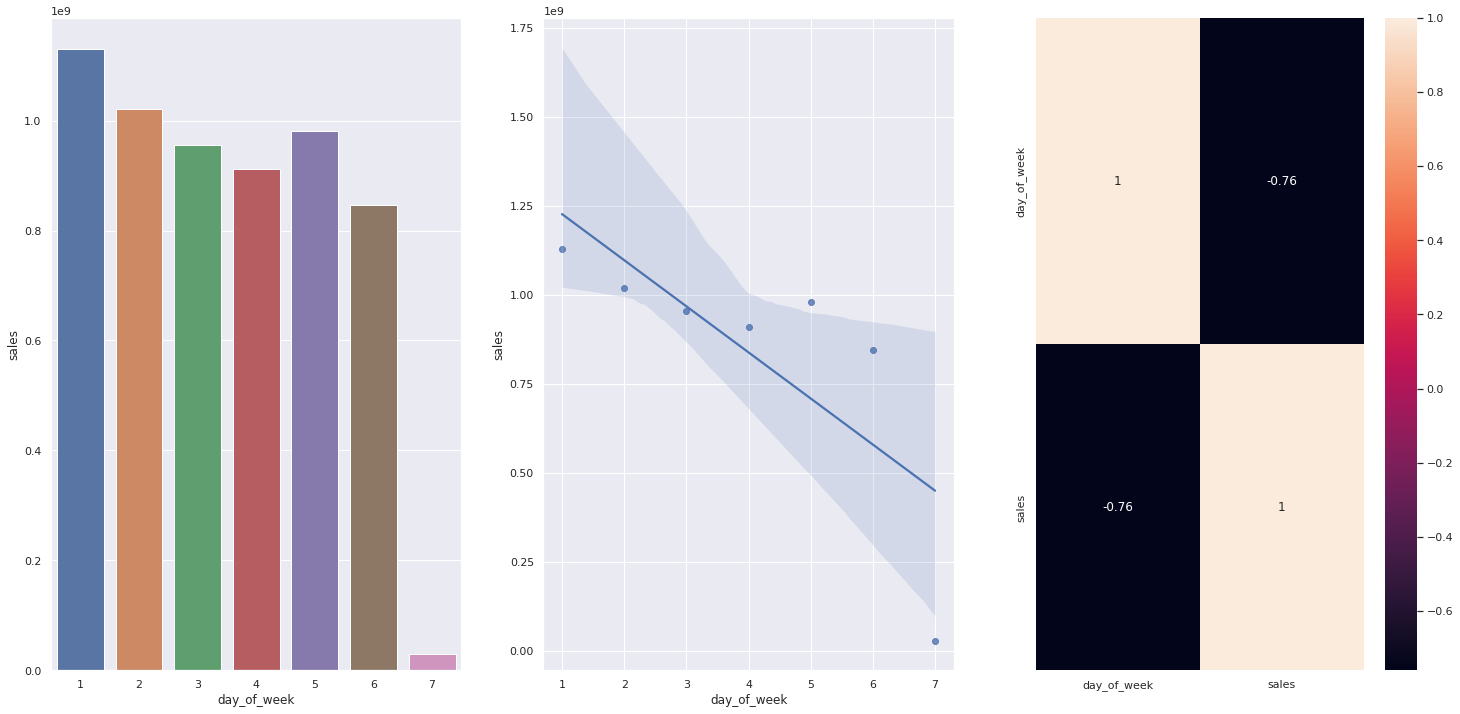

In [43]:
#Lojas deveriam vender menos aos finais de semana

aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);



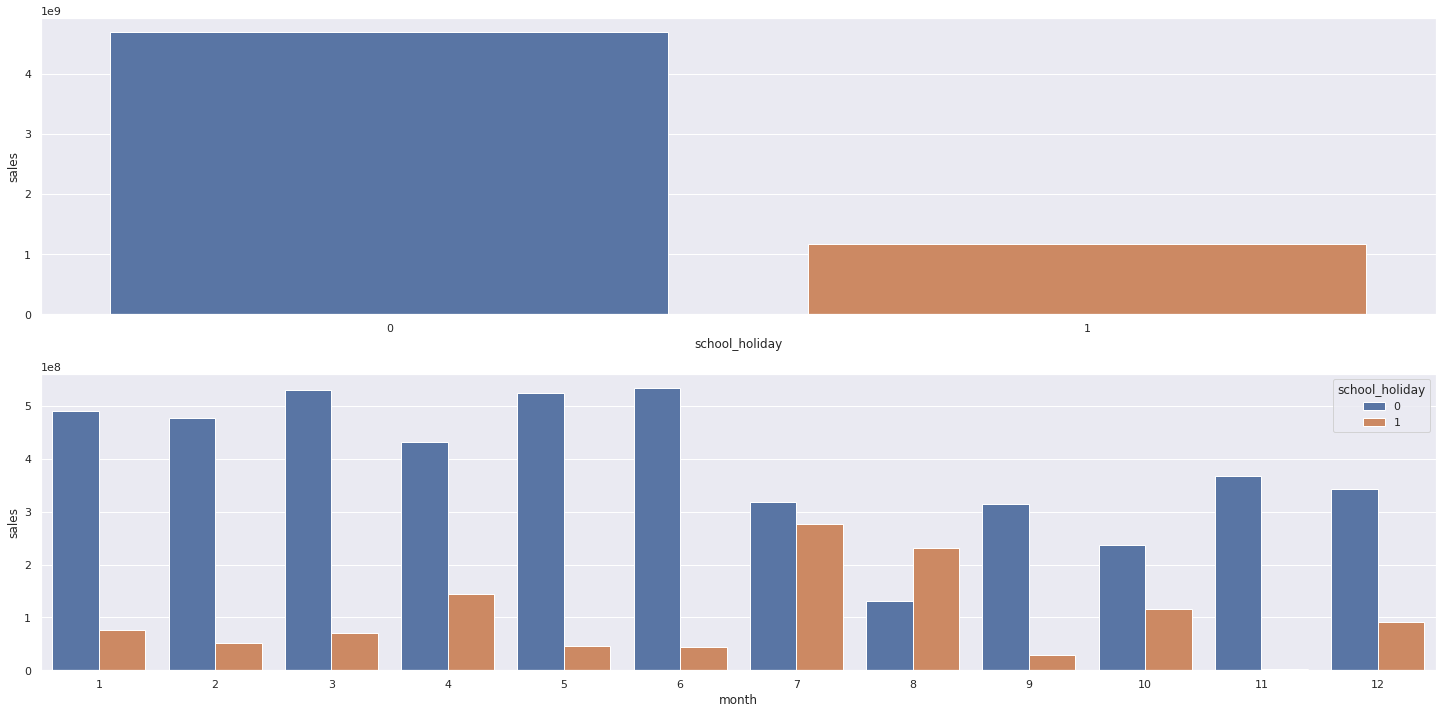

In [44]:
#Lojas deveriam vender menos durante os feriados

aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue ='school_holiday', data=aux2);


#A hipótese é verdadeira

##### 4.3 Analise Multivariada

a MOTIVAÇÃO da análise multivariada:

serve para reduzir a complexidade dos modelos que serão implementados mais adiante no ciclo CRISP.

######4.3.1 Numerical Atributes

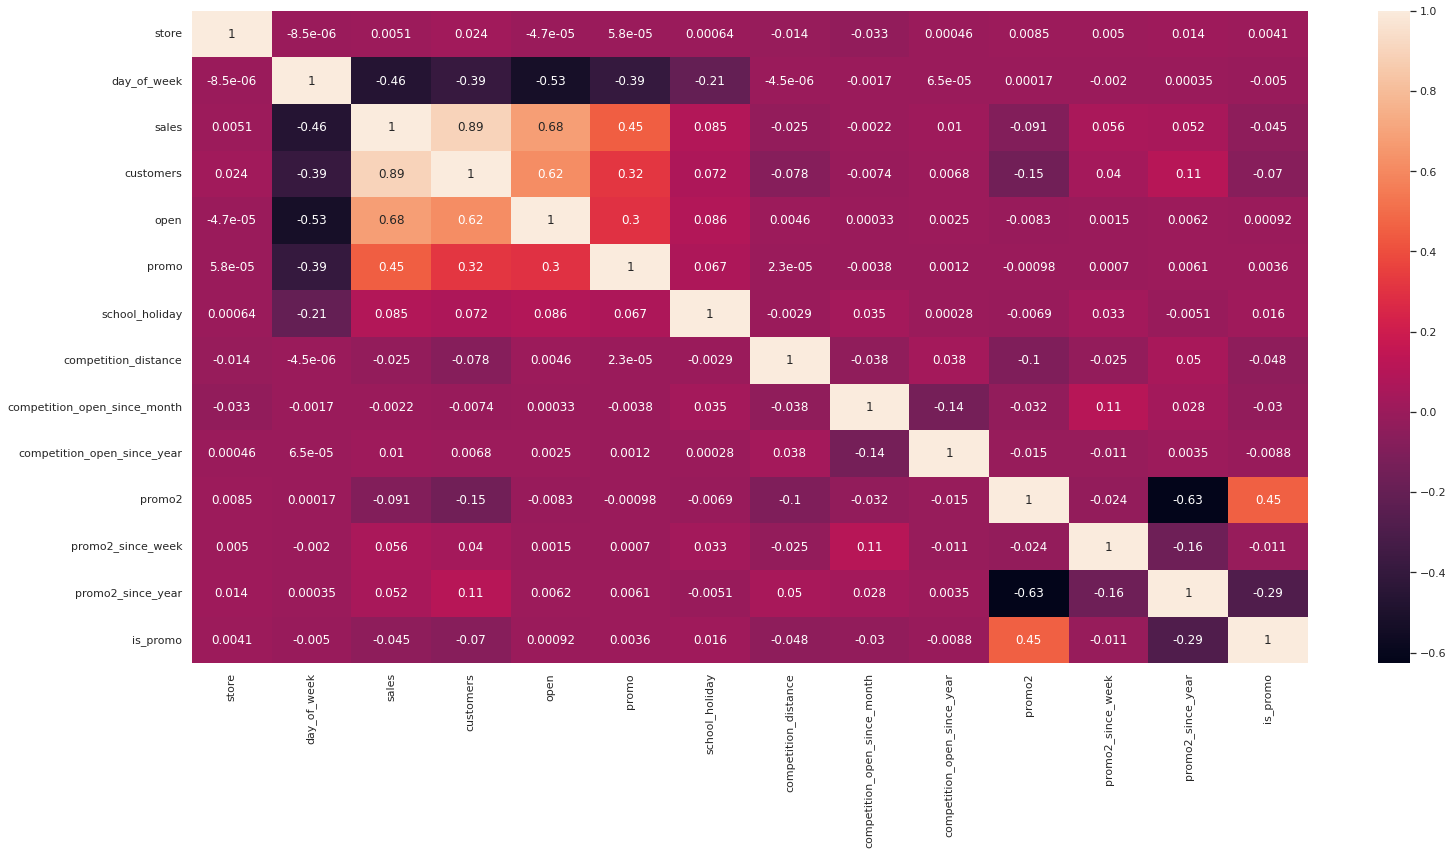

In [45]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

######4.3.2 Categorical Atributes



In [46]:
a.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
63559,5,4,2015-06-04,5807,1,public holiday,0,a,basic,29910.0,4,2015,0,23,2015,0,2015,6,4,23,15-22,2015-04-01,2,2015-06-01,0
63560,6,4,2015-06-04,5749,1,public holiday,0,a,basic,310.0,12,2013,0,23,2015,0,2015,6,4,23,15-22,2013-12-01,18,2015-06-01,0
63609,55,4,2015-06-04,5984,1,public holiday,0,a,basic,720.0,11,2004,0,23,2015,0,2015,6,4,23,15-22,2004-11-01,128,2015-06-01,0
63611,57,4,2015-06-04,9301,1,public holiday,0,d,extended,420.0,6,2014,0,23,2015,0,2015,6,4,23,15-22,2014-06-01,12,2015-06-01,0
63614,60,4,2015-06-04,10399,1,public holiday,0,d,extended,5540.0,10,2009,0,23,2015,0,2015,6,4,23,15-22,2009-10-01,69,2015-06-01,0


In [47]:
#only categorical data
a = df4.select_dtypes(include='object')

#categorical dataset
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000000,0.071065,0.067546
store_type,0.071065,1.000000,0.538456
assortment,0.067546,0.538456,1.000000


<Axes: >

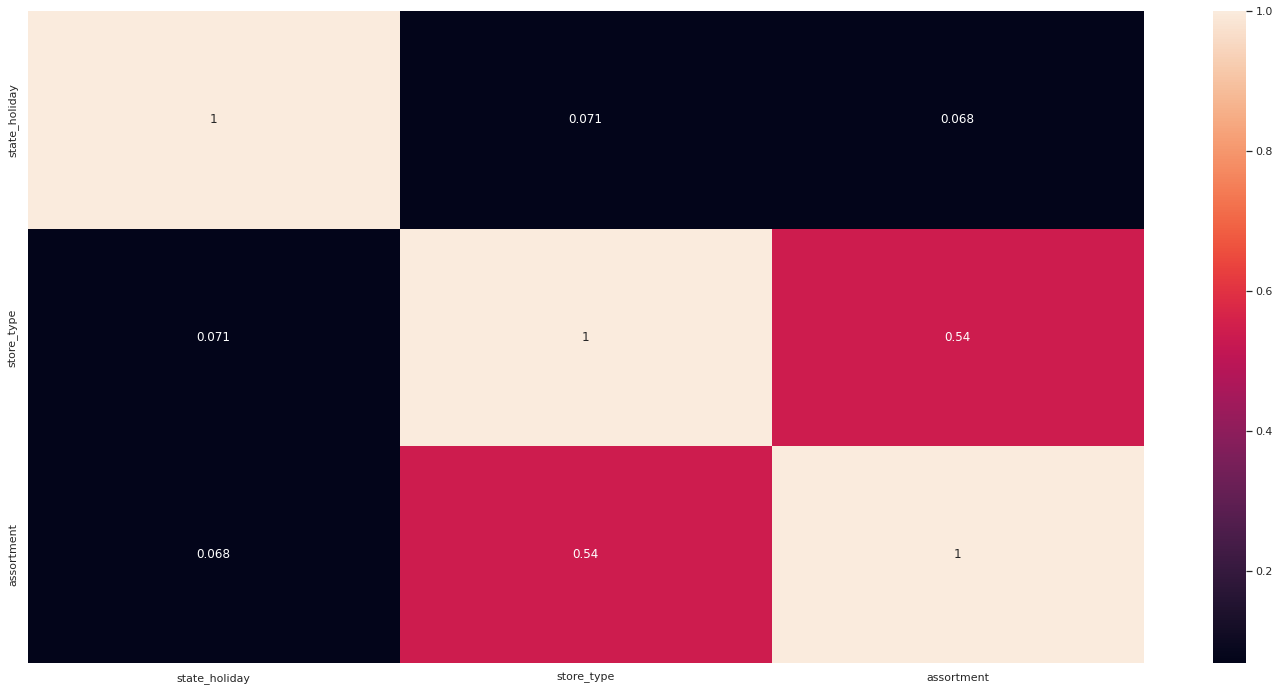

In [48]:
sns.heatmap(d, annot =  True)

#### 5.0 PREPARAÇÃO DE DADOS

O aprendizado da maioria dos algoritmos de ML é facilitado com dados númericos, na mesma escala.

In [49]:
df5 = df4.copy()

##### 5.1 Normalização:

* rescala o centro para 0 com desvio padrão igual a 1.

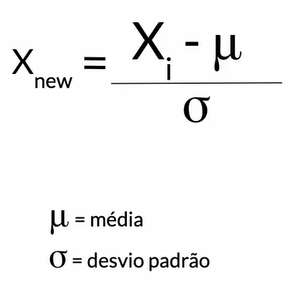





##### 5.2 Rescaling:

* rescala para o intervalo entre 0 e 1;
* Usado para distribuições não Gaussianas;

TÉCNICAS DE RESCALING:

**Min-Max Scaler:**

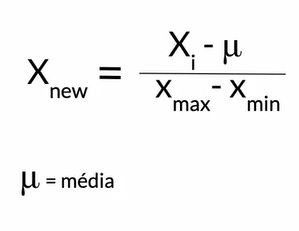

**Robust Scaler:**

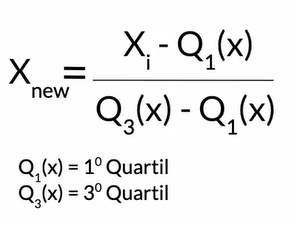

In [50]:
a= df5.select_dtypes(include = ['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

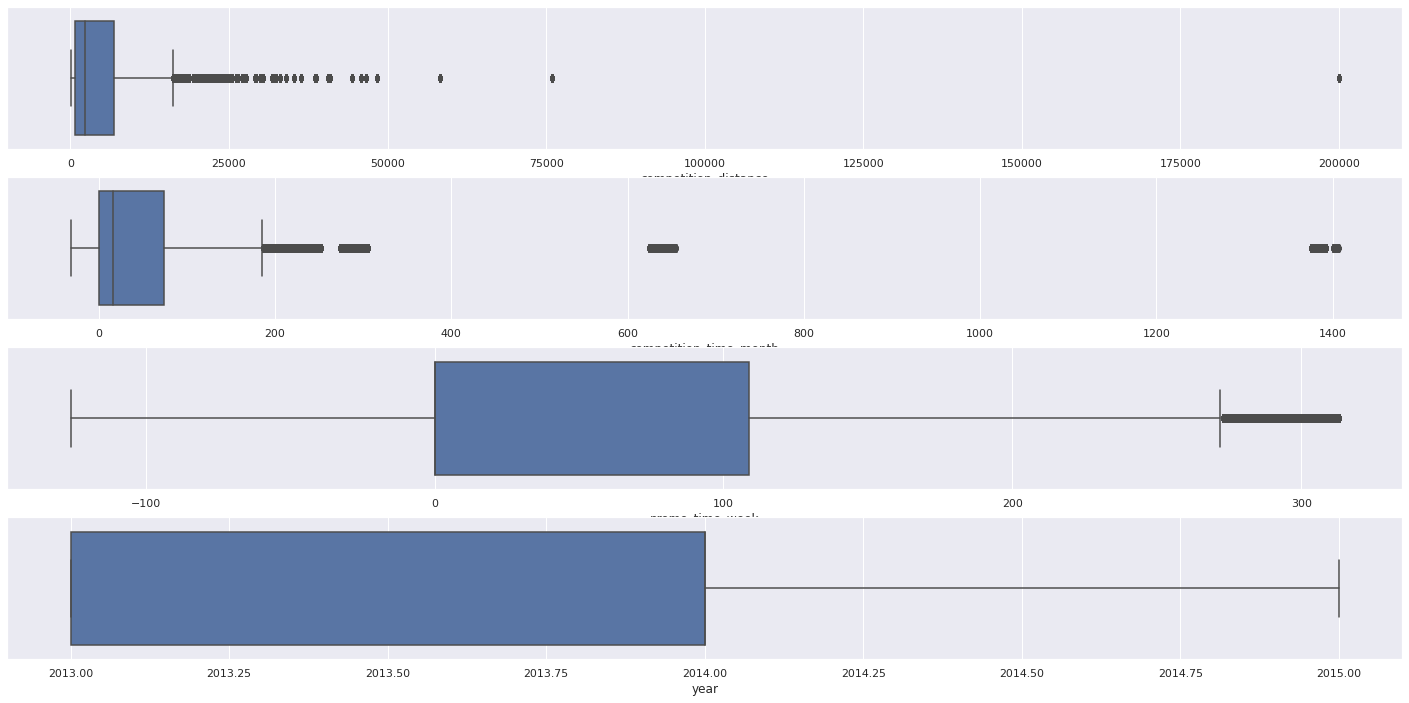

In [51]:
#instanciar os métodos:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
#---------> verificando outliers
plt.subplot(4,1,1)
sns.boxplot(df5['competition_distance']);

#---------> aplicando rescaling - RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
#---------> verificando outliers
plt.subplot(4,1,2)
sns.boxplot(df5['competition_time_month']);

#---------> aplicando rescaling - RobustScaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
#---------> verificando outliers
plt.subplot(4,1,3)
sns.boxplot(df5['promo_time_week']);

#---------> aplicando rescaling - RobustScaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)


# year
#---------> verificando outliers
plt.subplot(4,1,4)
sns.boxplot(df5['year']);

#---------> aplicando rescaling - RobustScaler
df5['year'] = mms.fit_transform(df5[['year']].values)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


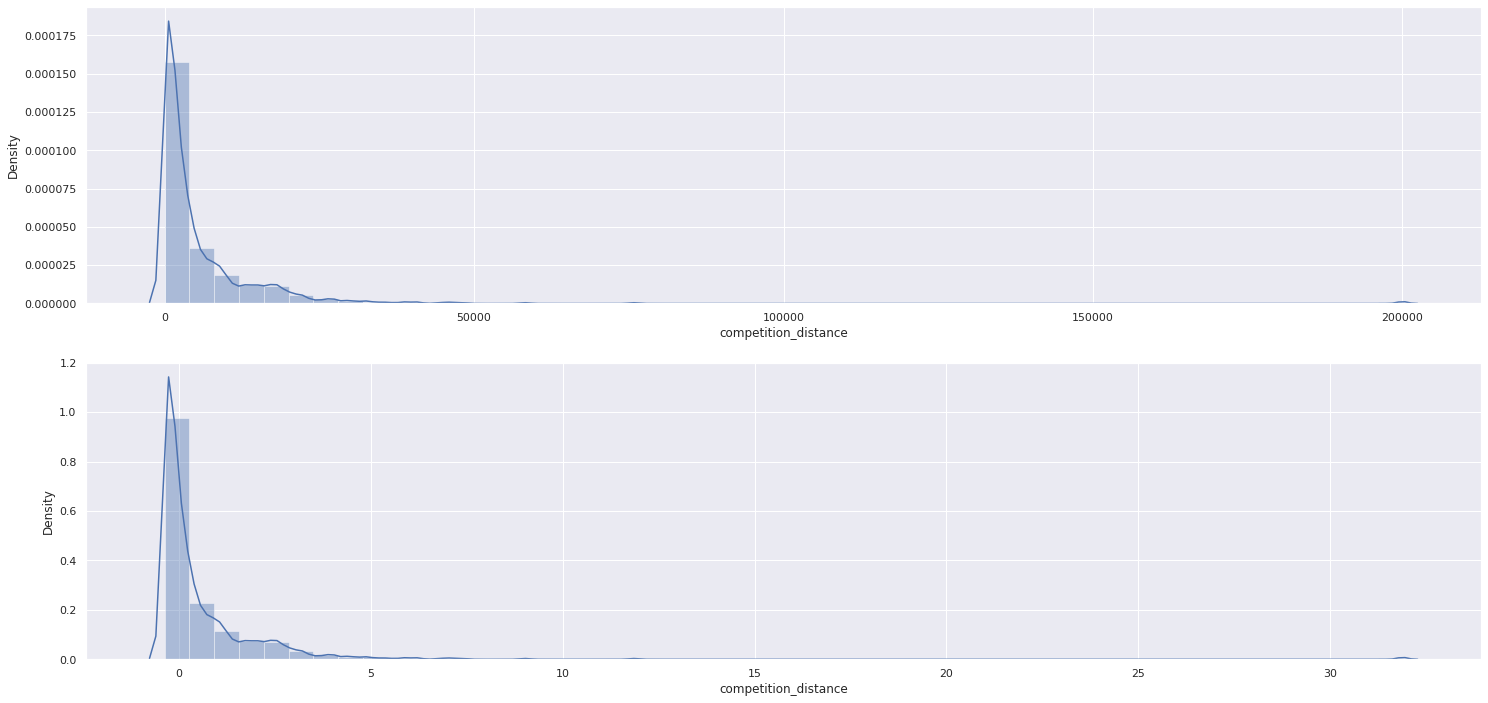

In [52]:
#comparando variáveis após o rescaling

plt.subplot(2,1,1)
sns.distplot(df4['competition_distance']);

plt.subplot(2,1,2)
sns.distplot(df5['competition_distance']);


##### 5.3 Transformação:

* Conversão de features categóricas para númericas (*enconding*);

Alguns tipos de encondig são:

1. One Hot Enconding

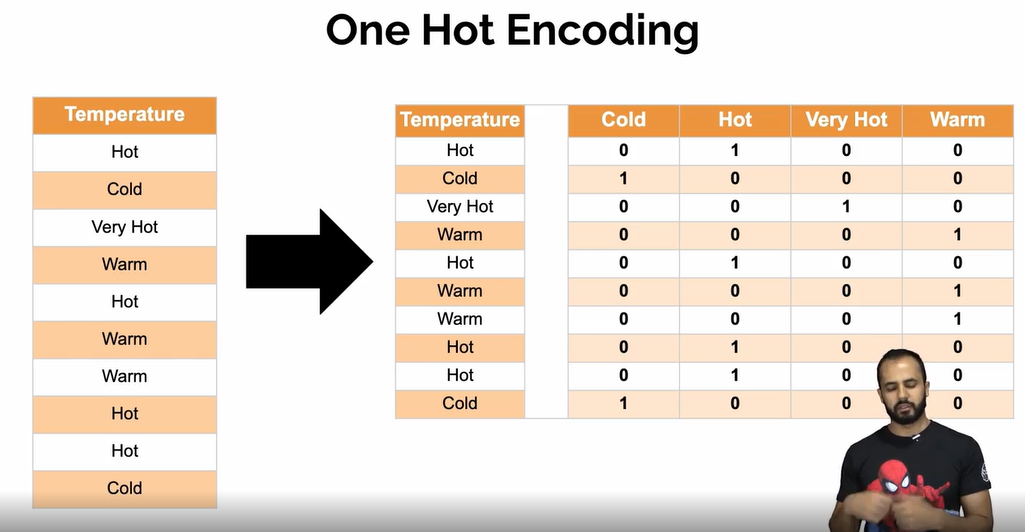

2. Label Encoding

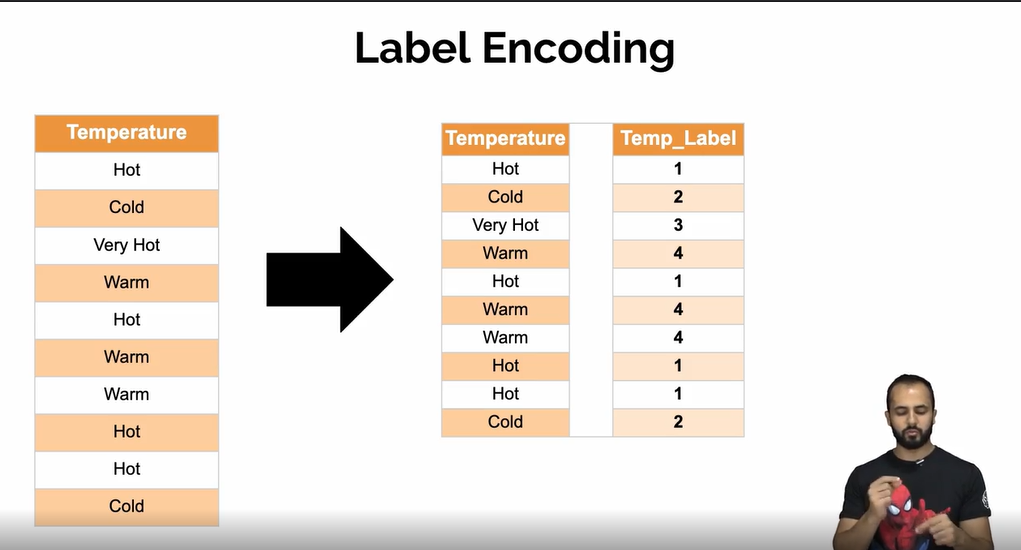

3. Ordinal Encoding

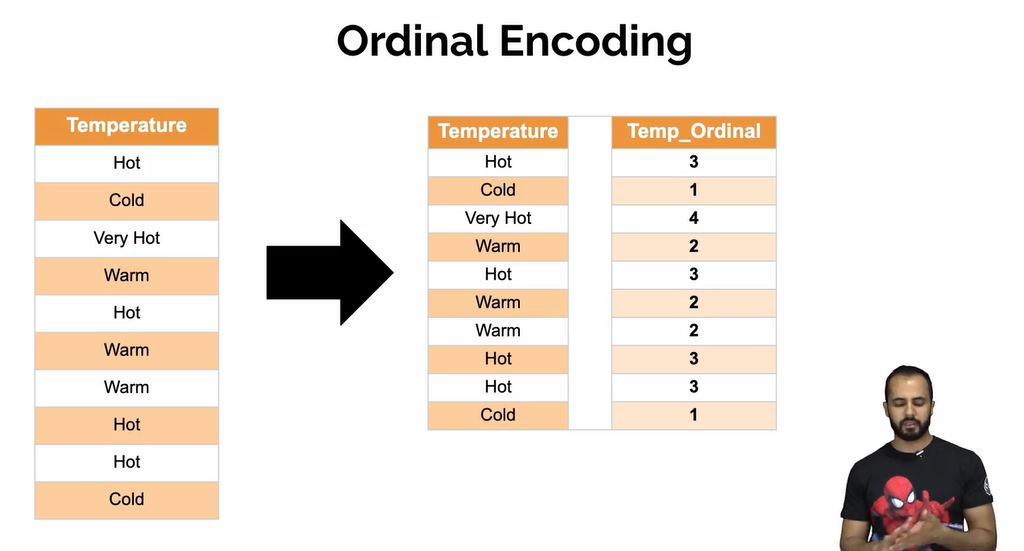

4. Target Encoding

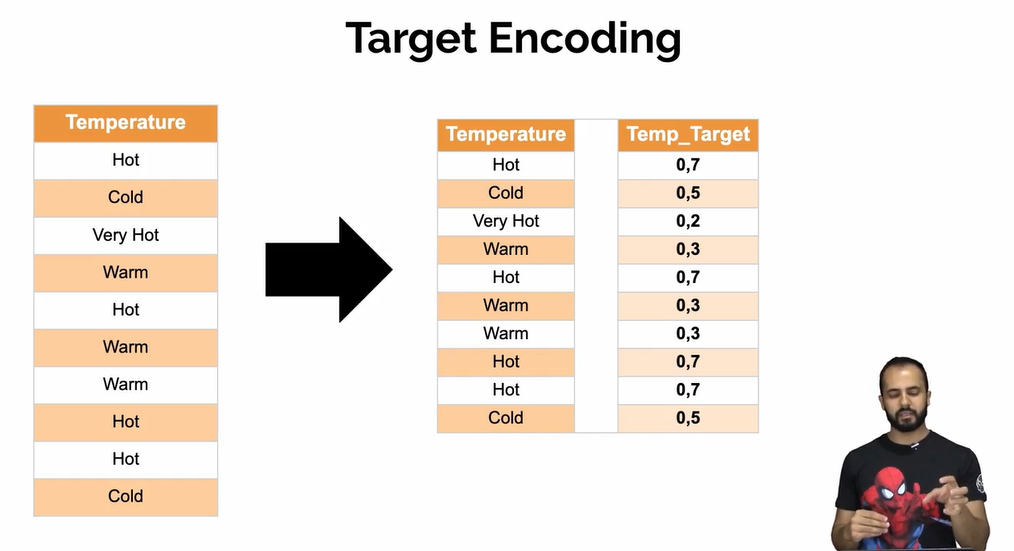

5. Frequency Encoding

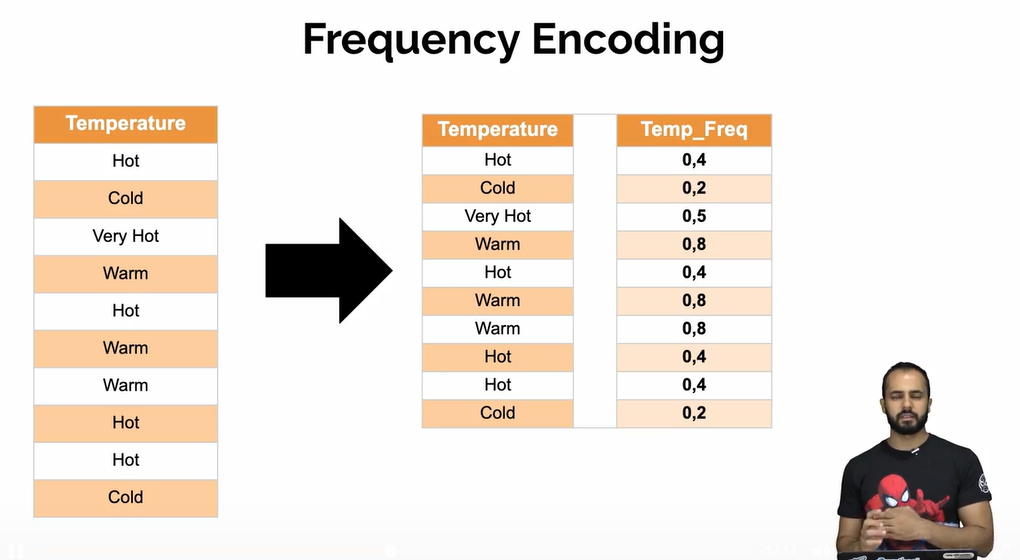

6. Embedding Encoding

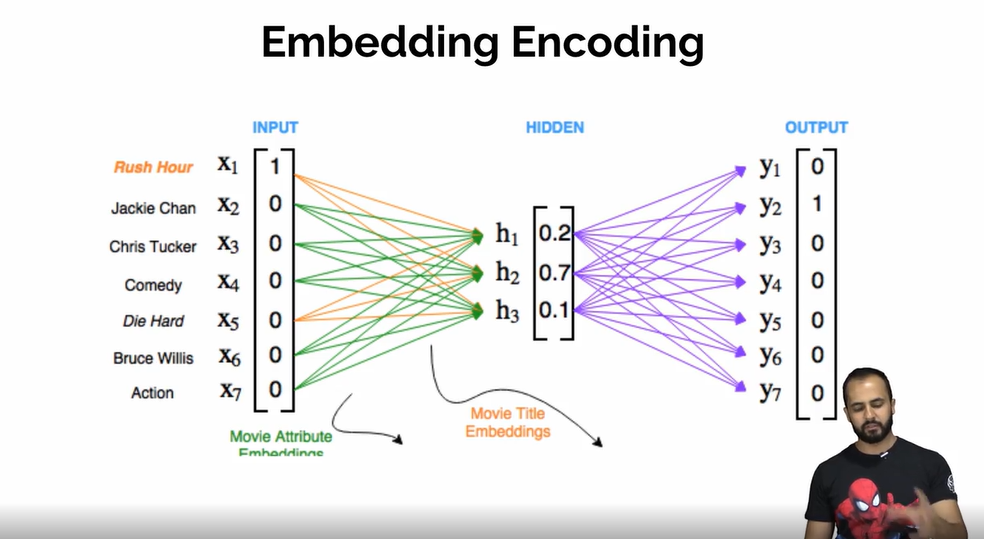

In [53]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encondig

assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

* Transformação de Natureza - procura trazer a *SKEW* para o centro, normalizando;

1. Logarithm Transformation

2. Box-Cox transformation

3. Cube-Root transformation

4. Square-Root transformation

5. Sina an Cosine transformation

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='sales', ylabel='Density'>

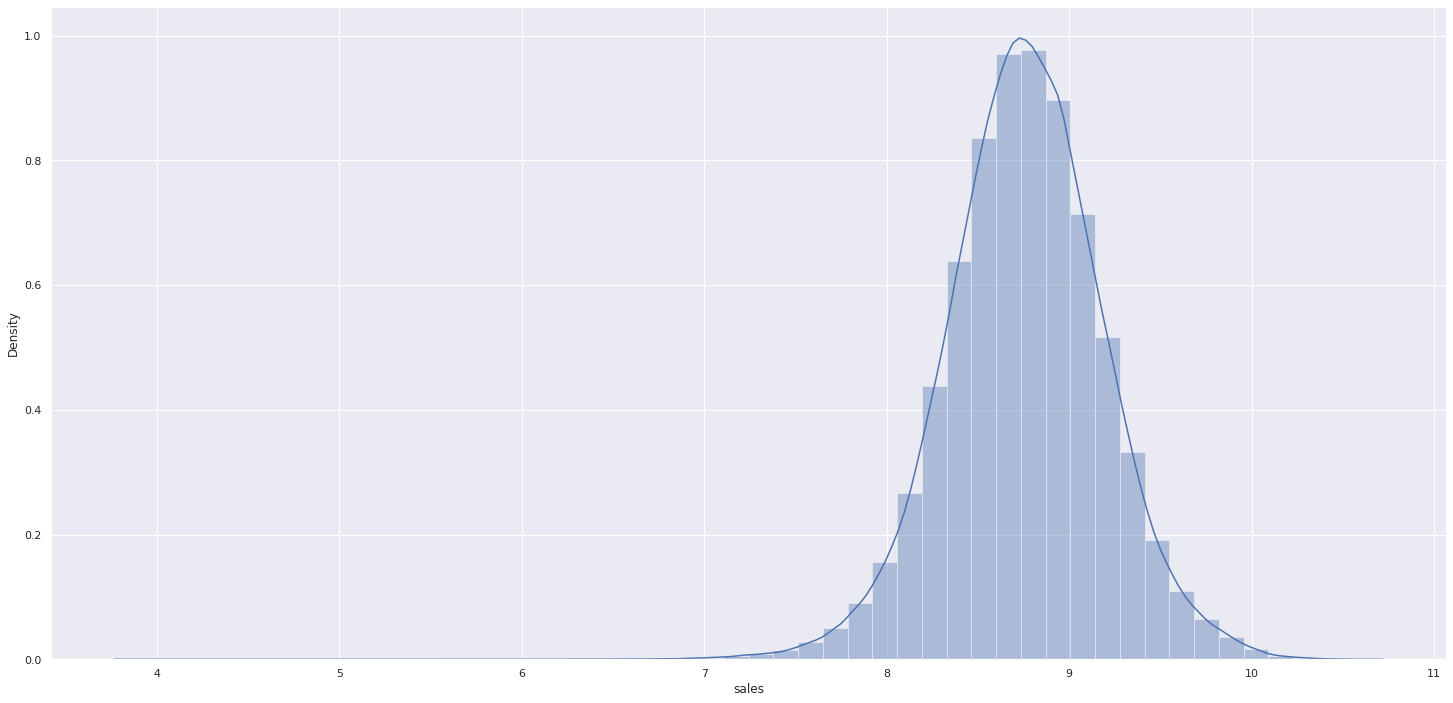

In [54]:
#____________________Response variable transformation____________________

df5['sales'] = np.log1p(df5['sales'])

sns.distplot(df5['sales'])

In [55]:
#________________________________________________variável de natureza ciclica________________________________________________

# month
df5['month_sin']=df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos']=df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin']=df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos']=df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# day of week 
df5['day_of_week_sin']=df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos']=df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# week of year
df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,15-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,15-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,15-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,15-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,15-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984


#### 6.0 SELEÇÃO DE VARIÁVEIS

Os 3 métodos de seleção de variáveis

1. Seleção Univariada (filter methods)

2. Seleção por importância (embedded methods)

3. Seleção por subset (wrapper methods)

######6.2.1 Metódo Boruta

In [57]:
df6 = df5.copy()

In [58]:
#6.2.1.1 Split dataframe into training and test dataset

cols_drop =['week_of_year', 'day','month', 'day_of_week', 'promo_since','competition_since','year_week']

df6 = df6.drop(cols_drop, axis = 1)

In [59]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [60]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
              
#test dataset              
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']              

print('training min date: {}'.format(X_train['date'].min()))
print('training max date: {}'.format(X_train['date'].max()))
print('\ntest min date: {}'.format(x_test['date'].min()))
print('test max date: {}'.format(x_test['date'].max()))

training min date: 2013-01-01 00:00:00
training max date: 2015-06-18 00:00:00

test min date: 2015-06-19 00:00:00
test max date: 2015-07-31 00:00:00


In [61]:
##6.2.1.2 Boruta as feature selector
#
##Training and test dataset for boruta
#x_train_n =  x_train.drop(['date','sales'], axis = 1).values
#y_train_n = y_train.values.ravel()
#
##define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs = -1)
#
##define boruta
#boruta = BorutaPy(rf, n_estimators ='auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

In [62]:
#cols_selected = boruta.support_.tolist()
#
##best features
#x_train_fs = x_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()
#
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

###### 6.3 Manual Feature Selection

In [63]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 
                        'competition_distance', 'competition_open_since_month', 
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 
                        'promo2_since_year', 'competition_time_month', 'promo_time_week', 
                        'month_sin','month_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 
                        'day_of_week_cos', 'week_of_year_sin','week_of_year_cos']

#columns to add 
feat_to_add = ['date','sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)
cols_selected_boruta_full


['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

#### 7. Modelos de machine learning

Tarefas dos algoritmos de machine learning:

- Supervisionada:
  * Modelo de Classificação ////// deep learning entra aqui //////
  * Modelo de Regressão
  * Modelo de Previsão *(Séries temporais)*
 
- Não-Supervisionada:
  * Clusterização/Agrupamento

- Semi-Supervisionado:
  * Reinforcement Learning  


Os 5 algoritmos de machine learning:
1. **Modelo de média (avg model)**: serve de baseline em relação as rede neurais, ou seja, rede neural desempenhou 60% de acc e a média tem 70% de acc, a rede neural está ruim

Os próximos servem geralmente para assumir posturas diante os dados, ou seja, por serem modelos mais simples, se apresentarem desempenhos interessantes 
2. **Linear Regression**
3. **Linear Regression Regularized** (lasso & ridge)

Modelos não-lineares
4. **Random Forest Regressor**
5. **XGBoost Regressor**

In [64]:
x_test = x_test[cols_selected_boruta]
x_train = X_train[cols_selected_boruta]


###### 7.1 Avg Model

In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on ='store')

yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


###### 7.2 Linear regression model

In [66]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


In [84]:
#cross validation:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name:,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


###### 7.3 Linear regression regularized model

In [82]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


In [85]:
#cross validation:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name:,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


#####7.4 Random Forest Regressor

In [68]:
#model
rf = RandomForestRegressor(n_estimators= 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.223482,0.099884,1010.266385


In [86]:
#cross validation:
rf_result_cv = cross_validation(x_training, 5, 'Randon Forrest Regressor', rf, verbose = True)
rf_result_cv


Kfold: 5

Kfold: 4

Kfold: 3

Kfold: 2

Kfold: 1


,Model Name:,MAE CV,MAPE CV,RMSE CV
0,Randon Forrest Regressor,837.24 +/- 218.09,0.12 +/- 0.02,1256.08 +/- 318.51


######7.5 XGBoost Regressor

In [69]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators= 100, 
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,891.311692,0.129075,1311.382812


In [87]:
#cross validation:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose = True)
xgb_result_cv


Kfold: 5

Kfold: 4

Kfold: 3

Kfold: 2

Kfold: 1


,Model Name:,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1044.44 +/- 180.94,0.14 +/- 0.02,1503.78 +/- 248.02


######7.6 compare model's performance

In [92]:
#single performance
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result, xgb_result])

modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.223482,0.099884,1010.266385
0,XGBoost Regressor,891.311692,0.129075,1311.382812
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735


In [94]:
#7.6.2 Real performance - cross validation

modelling_result = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv, xgb_result_cv])

modelling_result.sort_values('RMSE CV')

,Model Name:,MAE CV,MAPE CV,RMSE CV
0,Randon Forrest Regressor,837.24 +/- 218.09,0.12 +/- 0.02,1256.08 +/- 318.51
0,XGBoost,1044.44 +/- 180.94,0.14 +/- 0.02,1503.78 +/- 248.02
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


A performance *real dos modelos de machine learning*

Entendendo o Cross-Validation


Time series Cross-Validation
Cross-Validation Error

###### implementação do algoritmo de cross-validation

In [71]:
x_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709


In [72]:
x_training = X_train[cols_selected_boruta_full]              

In [75]:
model = Lasso(alpha = 0.01)
a = cross_validation (x_training , 5, 'Linear Regression Regularized', model, verbose = True)



Kfold: 5

Kfold: 4

Kfold: 3

Kfold: 2

Kfold: 1


In [76]:
a

,Model Name:,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


#### 8. Hyperparameter fine tuning

Motivação do fine tuning

é  "*o processo onde se encontra o conjunto de parametros que maximiza o aprendizado do modelo*"  

**3 estratégias de fine tuning**

1. **Random Search**
  * define valores para cada um dos hiperparametros aleatoriamente
  * **Vantagens**: Rápido e baixo custo
  * **Desvantagens**: Define os valores aleatoriamente (pode acabar nao escolhendo os melhores e até mesmo se repetir)
2. **Grid Search**
  * Define todas as combinações possíveis de valores que os hiperparâmetros podem assumir
  * **Vantagem**: Define os verdadeiros modelos que maximizam o aprendizado do modelo
  * **Desvantagem**: Muito demorado (meses por exemplo)
3. **Bayesian Search**
  * Define os valores para os hiperparâmetros seguindo a teoria de Bayes
  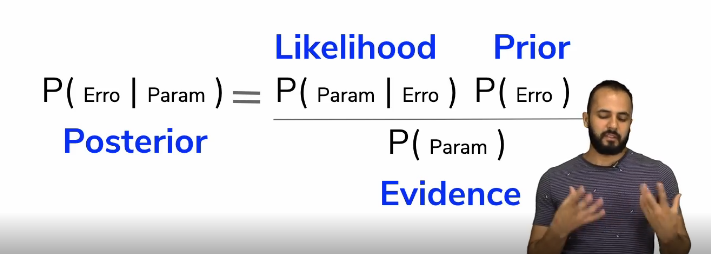
  * **Vantagens**: Define os valores para os hiperparâmetros baseado em aprendizados passados
  * **Desvantagens**: Apresenta certa complexidade, é mais rapido que o grid search e mais lento que o random

#####8.1 Random Search

In [107]:
import random
import warnings
warnings.filterwarnings('ignore')

param = {
    'n_estimators': [1500,1700,2500,3000,3500],
    'eta': [0.01,0.03],
    'max_depth': [3,5,9],
    'subsample': [0.1,0.5,0.7],
    'colsample_bytree': [0.3,0.7,0.9],
    'min_child_weight':[3,8,15]}
    
MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
  #choose for parameters randomly
  hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
  print(hp)
  #model
  model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators= hp['n_estimators'], 
                              eta =hp['eta'],
                              max_depth = hp['max_depth'],
                              subsample = hp['subsample'],
                              colsample_bytree = hp['colsample_bytree'],
                              min_child_weight = hp['min_child_weight'])
  #performance
  result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb)
  final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}


#####8.2 Final Model

In [74]:
param_tuned = {
  'n_estimators': 3000,
  'eta': 0.03,
  'max_depth': 5,
  'subsample': 0.7,
  'colsample_bytree': 0.7,
  'min_child_weight': 3}


In [ ]:
 #model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators= param_tuned['n_estimators'], 
                              eta =param_tuned['eta'],
                              max_depth = param_tuned['max_depth'],
                              subsample = param_tuned['subsample'],
                              colsample_bytree = param_tuned['colsample_bytree'],
                              min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)
                                                                                      
#predict
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned